In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import datetime as dt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.patches as mpatches

In [258]:
stores = pd.read_csv("Data/stores.csv")
holidays = pd.read_csv("Data/holidays_events.csv")
transactions = pd.read_csv("Data/transactions.csv")

In [259]:
train = pd.read_csv("Data/train_clean.csv")
train = train.iloc[:,1:]
train.head()

id        date  store_nbr        family  sales  onpromotion  new_years_day
0   0  2013-01-01          1    AUTOMOTIVE    0.0            0           True
1   2  2013-01-01          1        BEAUTY    0.0            0           True
2   5  2013-01-01          1  BREAD/BAKERY    0.0            0           True
3   7  2013-01-01          1      CLEANING    0.0            0           True
4   8  2013-01-01          1         DAIRY    0.0            0           True

In [264]:
holidays_column_names = ['date', 'holiday_type', 'locale', 'locale_name', 'holiday_name', 'transferred']
holidays.columns = holidays_column_names
holidays['date'] = pd.to_datetime(holidays['date'])
# Transfered == True means that day was more like a normal day
# I am going to remove the transfered days and remove "translado" from the holiday_name so its all one holiday
holidays = holidays.loc[holidays['transferred'] == False]
holidays['holiday_name'] = holidays['holiday_name'].str.replace('Traslado ','')
# Only Keep the holidays that appear more than once
holidays[holidays.holiday_name.duplicated(keep=False)]

# Make one df for national holidays
nat_holidays = holidays.loc[holidays['locale'] == 'National']
nat_holidays = nat_holidays.rename(columns = {'holiday_name' : 'national_holiday'})
nat_holidays = nat_holidays[['date', 'national_holiday']]
# Make one df for local and Regional holidays
local_reg_holidays = holidays.loc[holidays['locale'].isin(['Local', 'Regional'])]
local_reg_holidays = local_reg_holidays.rename(columns = {'holiday_name' : 'local_regional_holiday'})
local_reg_holidays = local_reg_holidays[['date', 'locale_name', 'national_holiday']]
local_reg_holidays

date holiday_type    locale locale_name  \
0   2012-03-02      Holiday     Local       Manta   
1   2012-04-01      Holiday  Regional    Cotopaxi   
2   2012-04-12      Holiday     Local      Cuenca   
3   2012-04-14      Holiday     Local    Libertad   
4   2012-04-21      Holiday     Local    Riobamba   
..         ...          ...       ...         ...   
338 2017-11-12      Holiday     Local      Ambato   
339 2017-12-05   Additional     Local       Quito   
341 2017-12-08      Holiday     Local        Loja   
342 2017-12-08     Transfer     Local       Quito   
344 2017-12-22      Holiday     Local     Salinas   

            local_regional_holiday  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
338        Independencia de Ambato        False  
339           Fundacion de Quito-1        False  
341              Fundacion de Loja        False  
342             Fundacion de Quito        False  
344       Cantonizacion de Salinas        False  

[172 rows x 6 columns]

In [267]:
def merge_and_format(df, stores, holidays, transactions):
    # Format as datetime
    df['date'] = pd.to_datetime(df['date'])
    # Merge with the stores data
    df_merged = pd.merge(df, stores, on='store_nbr')
    # Prep the holidays data
    holidays_column_names = ['date', 'holiday_type', 'locale', 'locale_name', 'holiday_name', 'transferred']
    holidays.columns = holidays_column_names
    holidays['date'] = pd.to_datetime(holidays['date'])
    # Transfered == True means that day was more like a normal day
    # I am going to remove the transfered days and remove "translado" from the holiday_name so its all one holiday
    holidays = holidays.loc[holidays['transferred'] == False]
    holidays['holiday_name'] = holidays['holiday_name'].str.replace('Traslado ','')
    # Only Keep the holidays that appear more than once
    holidays[holidays.holiday_name.duplicated(keep=False)]
    
    # Make one df for national holidays
    nat_holidays = holidays.loc[holidays['locale'] == 'National']
    nat_holidays = nat_holidays.rename(columns = {'holiday_name' : 'national_holiday'})
    nat_holidays = nat_holidays[['date', 'national_holiday']]
    # Make one df for local and Regional holidays
    local_reg_holidays = holidays.loc[holidays['locale'].isin(['Local', 'Regional'])]
    local_reg_holidays = local_reg_holidays.rename(columns = {'holiday_name' : 'local_regional_holiday', 'locale_name':'city'})
    local_reg_holidays = local_reg_holidays[['date', 'city', 'local_regional_holiday']]
    # Merge with the national holidays
    df_merged = df_merged.merge(nat_holidays, on='date', how="left")
    df_merged['national_holiday'] = df_merged['national_holiday'].fillna('no_holiday')
    # Merge with the local holidays
    df_merged = df_merged.merge(local_reg_holidays, on=['date', 'city'], how="left")
    df_merged['local_regional_holiday'] = df_merged['local_regional_holiday'].fillna('no_holiday')
    # transactions
    transactions['date'] = pd.to_datetime(transactions['date'])
    df_merged = df_merged.merge(transactions, on=['date', 'store_nbr'], how="left").dropna()
    df_merged["store_nbr"] = df_merged["store_nbr"].astype(str)
    df_merged['cluster'] = df_merged['cluster'].astype(str)    
    return df_merged
train = merge_and_format(train, stores, holidays, transactions)

In [268]:
train.head()

id       date store_nbr        family    sales  onpromotion  \
308  561 2013-01-01        25    AUTOMOTIVE    0.000            0   
309  563 2013-01-01        25        BEAUTY    2.000            0   
310  566 2013-01-01        25  BREAD/BAKERY  180.589            0   
311  568 2013-01-01        25      CLEANING  186.000            0   
312  569 2013-01-01        25         DAIRY  143.000            0   

     new_years_day     city        state type cluster    national_holiday  \
308           True  Salinas  Santa Elena    D       1  Primer dia del ano   
309           True  Salinas  Santa Elena    D       1  Primer dia del ano   
310           True  Salinas  Santa Elena    D       1  Primer dia del ano   
311           True  Salinas  Santa Elena    D       1  Primer dia del ano   
312           True  Salinas  Santa Elena    D       1  Primer dia del ano   

    local_regional_holiday  transactions  
308             no_holiday         770.0  
309             no_holiday         770.0  
310             no_holiday         770.0  
311             no_holiday         770.0  
312             no_holiday         770.0

In [270]:
def create_features(df, train=True): 
    # display(df.head())
    # Time Features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["weekday"] = df["date"].dt.weekday
    df["week_of_year"] = df["date"].dt.isocalendar().week
    df["day_of_year"] = df["date"].dt.dayofyear
    df["quarter"] = df["date"].dt.quarter
    df['day_cat'] = df['date'].dt.day_name()
    df["month_cat"] = df["date"].dt.month_name()
    # Categorical Features
    df['is_holiday'] = np.where((df['national_holiday'] == 'no_holiday') | (df['local_regional_holiday'] == 'no_holiday'), "not_holiday", "holiday")
    # Interactions Variables
    df['store_fam_day_interaction'] = df['store_nbr'] + "_" + df['family'] + "_" + df['day_cat']
    df['store_fam_interaction'] = df['store_nbr'] + "_" + df['family']
    df['store_holiday_interaction'] = df['store_nbr'] + "_" + df['is_holiday']
    df['store_day_interaction'] = df['store_nbr'] + "_" + df['day_cat']
    df['store_month_interaction'] = df['store_nbr'] + "_" + df['month_cat']
    df['type_day_interaction'] = df['type'] + "_" + df['day_cat']
    df['local_holiday_store'] = df['local_regional_holiday']  + "_" + df['store_nbr']
    df["dec"] = np.where(df["month_cat"] == "December", 'dec', 'not_dec')
    df['dec_day_interaction'] = df['day_cat'] + "_" + df['dec']
    for lag in [1, 7, 30]:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
        df[f'onpromotion_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(lag)
    # df = df.dropna(subset=['trans_lag_30'])  # Remove rows with missing lags
    return df

In [271]:
train = create_features(train)

In [143]:
train['trans_per_sale'] = (train['sales'] / train['transactions'])

In [272]:
train.head()

id       date store_nbr        family    sales  onpromotion  \
308  561 2013-01-01        25    AUTOMOTIVE    0.000            0   
309  563 2013-01-01        25        BEAUTY    2.000            0   
310  566 2013-01-01        25  BREAD/BAKERY  180.589            0   
311  568 2013-01-01        25      CLEANING  186.000            0   
312  569 2013-01-01        25         DAIRY  143.000            0   

     new_years_day     city        state type  ... type_day_interaction  \
308           True  Salinas  Santa Elena    D  ...            D_Tuesday   
309           True  Salinas  Santa Elena    D  ...            D_Tuesday   
310           True  Salinas  Santa Elena    D  ...            D_Tuesday   
311           True  Salinas  Santa Elena    D  ...            D_Tuesday   
312           True  Salinas  Santa Elena    D  ...            D_Tuesday   

    local_holiday_store      dec  dec_day_interaction  sales_lag_1  \
308       no_holiday_25  not_dec      Tuesday_not_dec          NaN   
309       no_holiday_25  not_dec      Tuesday_not_dec          NaN   
310       no_holiday_25  not_dec      Tuesday_not_dec          NaN   
311       no_holiday_25  not_dec      Tuesday_not_dec          NaN   
312       no_holiday_25  not_dec      Tuesday_not_dec          NaN   

     onpromotion_lag_1  sales_lag_7  onpromotion_lag_7  sales_lag_30  \
308                NaN          NaN                NaN           NaN   
309                NaN          NaN                NaN           NaN   
310                NaN          NaN                NaN           NaN   
311                NaN          NaN                NaN           NaN   
312                NaN          NaN                NaN           NaN   

     onpromotion_lag_30  
308                 NaN  
309                 NaN  
310                 NaN  
311                 NaN  
312                 NaN  

[5 rows x 39 columns]

In [273]:
# Identify feature types
num_features = ["sales_lag_1", "sales_lag_7", "sales_lag_30"]
cat_features = ["store_fam_day_interaction", "national_holiday", "local_holiday_store"]

# Define transformations
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

ridge_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

Fold 1:
Train Date Range: 2013-01-01 00:00:00 - 2014-01-25 00:00:00
Validation Date Range: 2014-01-25 00:00:00 - 2014-12-20 00:00:00
Fold 1: Train Size = 377297, Validation Size = 377293
Fold 2:
Train Date Range: 2013-01-01 00:00:00 - 2014-12-20 00:00:00
Validation Date Range: 2014-12-20 00:00:00 - 2015-10-09 00:00:00
Fold 2: Train Size = 754590, Validation Size = 377293
Fold 3:
Train Date Range: 2013-01-01 00:00:00 - 2015-10-09 00:00:00
Validation Date Range: 2015-10-09 00:00:00 - 2016-05-25 00:00:00
Fold 3: Train Size = 1131883, Validation Size = 377293
⚠️ High MSE detected in Fold 3 (189436.73) ⚠️


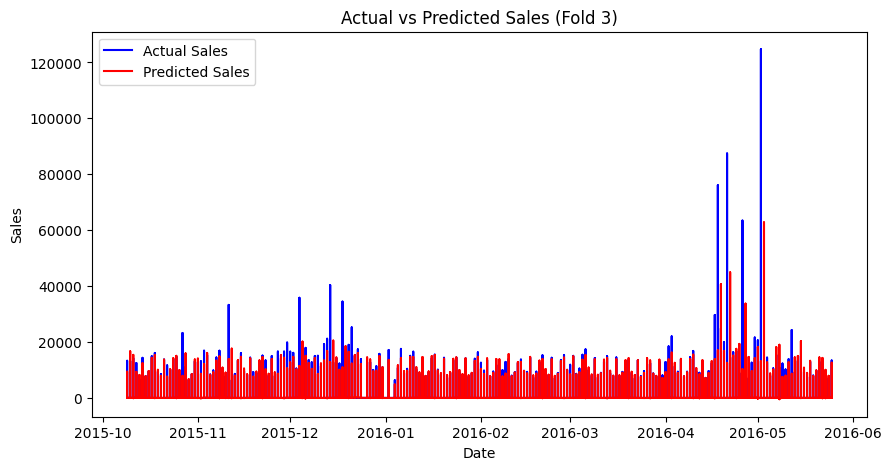

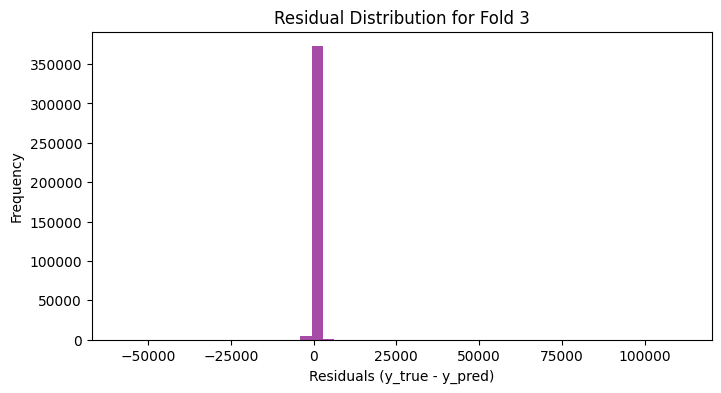

Train Set Mean Sales: 396.53, Std Dev: 1058.19
Validation Set Mean Sales (Fold 3): 483.93, Std Dev: 1355.82
Fold 4:
Train Date Range: 2013-01-01 00:00:00 - 2016-05-25 00:00:00
Validation Date Range: 2016-05-25 00:00:00 - 2017-01-10 00:00:00
Fold 4: Train Size = 1509176, Validation Size = 377293
Fold 5:
Train Date Range: 2013-01-01 00:00:00 - 2017-01-10 00:00:00
Validation Date Range: 2017-01-10 00:00:00 - 2017-08-15 00:00:00
Fold 5: Train Size = 1886469, Validation Size = 377293
MSE scores across folds: [56173.58922156289, 95978.40656158073, 189436.72825155657, 86307.80514030805, 73994.61401788956]
Average MSE: 100378.23


In [275]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Define the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Initialize a list to store errors
mse_scores = []

# Time Series Cross Validation
fold_num = 1  # Track the fold number
for train_index, val_index in tscv.split(train):
    # Extract date ranges
    train_start, train_end = train.iloc[train_index]['date'].min(), train.iloc[train_index]['date'].max()
    val_start, val_end = train.iloc[val_index]['date'].min(), train.iloc[val_index]['date'].max()

    print(f"Fold {fold_num}:")
    print(f"Train Date Range: {train_start} - {train_end}")
    print(f"Validation Date Range: {val_start} - {val_end}")
    print(f"Fold {fold_num}: Train Size = {len(train_index)}, Validation Size = {len(val_index)}")

    print("="*50)

    # Split data into training and validation
    X_train, X_val = train.iloc[train_index][num_features + cat_features], train.iloc[val_index][num_features + cat_features]
    y_train, y_val = train.iloc[train_index]['sales'], train.iloc[val_index]['sales']

    # Train the Ridge regression model
    ridge_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = ridge_model.predict(X_val)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

    # Identify and analyze problematic fold (the one with extremely high MSE)
    if mse > 100_000:  # Arbitrary threshold to flag an unusual fold
        print(f"⚠️ High MSE detected in Fold {fold_num} ({mse:.2f}) ⚠️")
        
        # Plot actual vs predicted sales for Fold X
        plt.figure(figsize=(10, 5))
        plt.plot(train.iloc[val_index]['date'], y_val, label='Actual Sales', color='blue')
        plt.plot(train.iloc[val_index]['date'], y_pred, label='Predicted Sales', color='red')
        plt.legend()
        plt.title(f"Actual vs Predicted Sales (Fold {fold_num})")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.show()

        # Compute residuals and plot distribution
        residuals = y_val - y_pred
        plt.figure(figsize=(8, 4))
        plt.hist(residuals, bins=50, color='purple', alpha=0.7)
        plt.title(f"Residual Distribution for Fold {fold_num}")
        plt.xlabel("Residuals (y_true - y_pred)")
        plt.ylabel("Frequency")
        plt.show()

        # Compare mean and std deviation of sales
        print(f"Train Set Mean Sales: {y_train.mean():.2f}, Std Dev: {y_train.std():.2f}")
        print(f"Validation Set Mean Sales (Fold {fold_num}): {y_val.mean():.2f}, Std Dev: {y_val.std():.2f}")
    
    fold_num += 1  # Move to the next fold

# Print the cross-validation MSE scores
print(f"MSE scores across folds: {mse_scores}")
print(f"Average MSE: {np.mean(mse_scores):.2f}")


In [182]:
# Define the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Initialize a list to store errors
mse_scores = []

# Time Series Cross Validation
for train_index, val_index in tscv.split(train):
    # Split data into training and validation
    X_train, X_val = train.iloc[train_index][num_features + cat_features], train.iloc[val_index][num_features + cat_features]
    y_train, y_val = train.iloc[train_index]['sales'], train.iloc[val_index]['sales']

    # Train the Ridge regression model
    ridge_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = ridge_model.predict(X_val)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

# Print the cross-validation MSE scores
print(f"MSE scores across folds: {mse_scores}")
print(f"Average MSE: {np.mean(mse_scores)}")

MSE scores across folds: [53360.05978364966, 58771.14859349319, 5841691.744646389, 86737.87961419941, 72856.35220733733]
Average MSE: 1222683.4369690137


In [183]:
resid = train.iloc[val_index][['date', 'store_nbr', 'family', 'state', 'city','type','day_cat','holiday_name', 'sales']].reset_index(drop = True)
resid['y_pred'] = y_pred
resid['y_pred'] = resid['y_pred'].mask(resid['y_pred'] < 0, 0)
resid['residuals'] = resid['sales'] - resid['y_pred']
resid.head()

date store_nbr               family   state   city type  day_cat  \
0 2017-01-10        53  HOME AND KITCHEN II  Manabi  Manta    D  Tuesday   
1 2017-01-10        53      HOME APPLIANCES  Manabi  Manta    D  Tuesday   
2 2017-01-10        53            HOME CARE  Manabi  Manta    D  Tuesday   
3 2017-01-10        53           LADIESWEAR  Manabi  Manta    D  Tuesday   
4 2017-01-10        53      LAWN AND GARDEN  Manabi  Manta    D  Tuesday   

  holiday_name  sales      y_pred  residuals  
0   no_holiday   22.0    5.250847  16.749153  
1   no_holiday    0.0    0.000000   0.000000  
2   no_holiday  195.0  191.910163   3.089837  
3   no_holiday    9.0    0.000000   9.000000  
4   no_holiday    7.0    0.000000   7.000000

In [173]:
resid.sort_values('residuals')

date store_nbr     family      state       city type   day_cat  \
141938 2017-04-03        45  GROCERY I  Pichincha      Quito    A    Monday   
142367 2017-04-03         9  GROCERY I  Pichincha      Quito    B    Monday   
141929 2017-04-03        45  BEVERAGES  Pichincha      Quito    A    Monday   
158620 2017-04-13        32  GROCERY I     Guayas  Guayaquil    C  Thursday   
140186 2017-04-02        44  BEVERAGES  Pichincha      Quito    A    Sunday   
...           ...       ...        ...        ...        ...  ...       ...   
11038  2017-01-17        26  BEVERAGES     Guayas  Guayaquil    D   Tuesday   
122633 2017-03-23        32  GROCERY I     Guayas  Guayaquil    C  Thursday   
286920 2017-06-25        54  BEVERAGES     Manabi  El Carmen    C    Sunday   
155195 2017-04-11        32  GROCERY I     Guayas  Guayaquil    C   Tuesday   
140657 2017-04-02         9  GROCERY I  Pichincha      Quito    B    Sunday   

               holiday_name      sales        y_pred     residuals  
141938           no_holiday    731.000  12064.693076 -11333.693076  
142367           no_holiday  10260.961  19594.802344  -9333.841344  
141929           no_holiday    624.000   9433.314181  -8809.314181  
158620  Fundacion de Cuenca   1433.000   9942.218339  -8509.218339  
140186           no_holiday  11455.000  19026.034569  -7571.034569  
...                     ...        ...           ...           ...  
11038            no_holiday  13409.000   1759.613283  11649.386717  
122633           no_holiday  14250.000   2153.828773  12096.171227  
286920           no_holiday  17614.000   3975.270102  13638.729898  
155195           no_holiday  20602.000   2586.430765  18015.569235  
140657           no_holiday  38422.625  12956.516849  25466.108151  

[376201 rows x 11 columns]

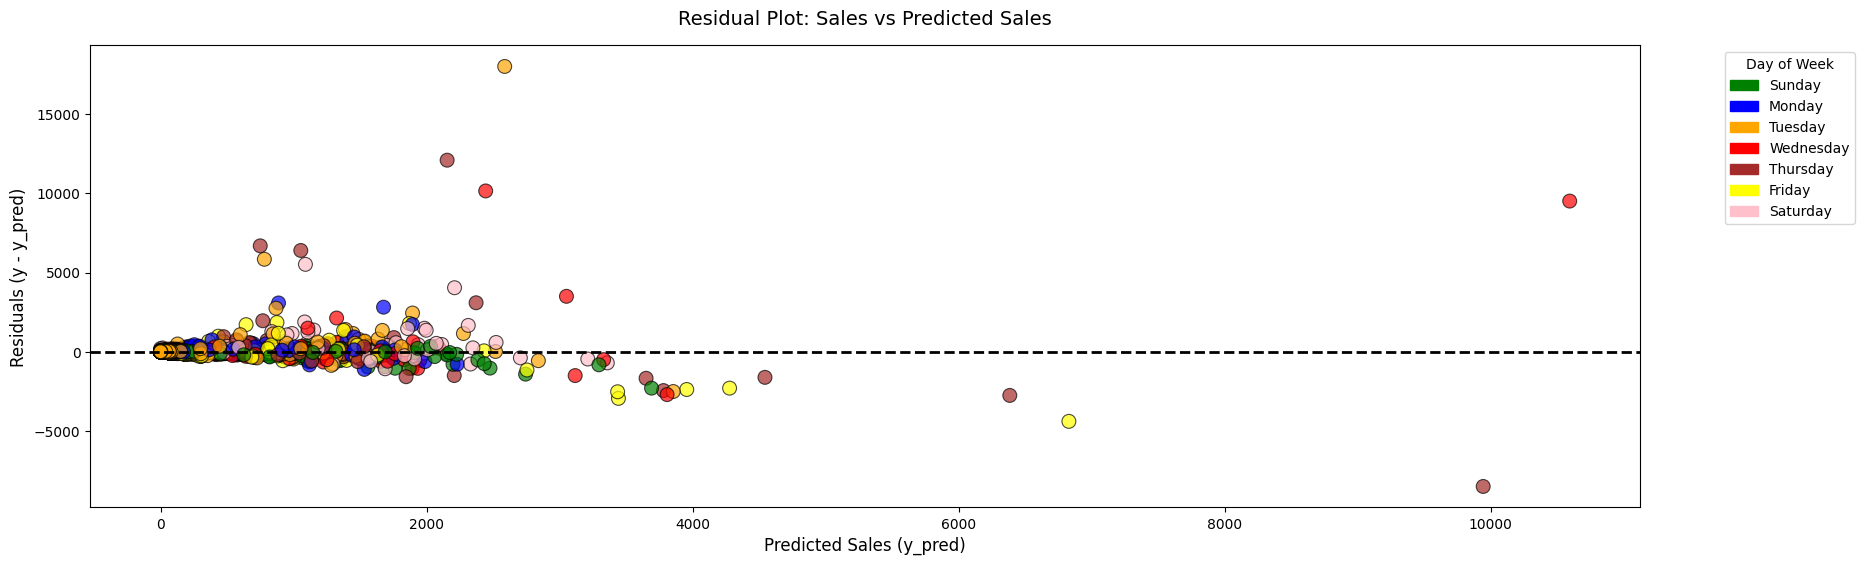

In [151]:
store_1_resid = resid.loc[resid['store_nbr'] == "32"]
# Define color mapping for days
day_colors = {
    'Sunday': 'green', 'Monday': 'blue', 'Tuesday': 'orange',
    'Wednesday': 'red', 'Thursday': 'brown', 'Friday': 'yellow', 'Saturday': 'pink'
}

# Create the plot
plt.figure(figsize=(20, 6))

# Seaborn scatter plot with categorical coloring
sns.scatterplot(data=store_1_resid, x='y_pred', y='residuals', hue='day_cat', 
                palette=day_colors, alpha=0.7, edgecolor='k', s=100)

# Add a horizontal reference line at 0
plt.axhline(0, color='black', lw=2, linestyle='--')

# Labels and title
plt.title('Residual Plot: Sales vs Predicted Sales', fontsize=14, pad=15)
plt.xlabel('Predicted Sales (y_pred)', fontsize=12)
plt.ylabel('Residuals (y - y_pred)', fontsize=12)

# Custom legend using Matplotlib patches
handles = [mpatches.Patch(color=color, label=day) for day, color in day_colors.items()]
plt.legend(handles=handles, title="Day of Week", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [174]:
train_32 = resid.loc[resid['store_nbr'] == "32"]

In [179]:
train_32.groupby(['family','date']).sum().sort_values(by="sales")

store_nbr   state       city type    day_cat  \
family          date                                                      
AUTOMOTIVE      2017-01-30        32  Guayas  Guayaquil    C     Monday   
                2017-01-13        32  Guayas  Guayaquil    C     Friday   
                2017-02-21        32  Guayas  Guayaquil    C    Tuesday   
HOME APPLIANCES 2017-06-23        32  Guayas  Guayaquil    C     Friday   
                2017-06-22        32  Guayas  Guayaquil    C   Thursday   
...                              ...     ...        ...  ...        ...   
CLEANING        2017-05-04        32  Guayas  Guayaquil    C   Thursday   
GROCERY I       2017-05-03        32  Guayas  Guayaquil    C  Wednesday   
                2017-03-23        32  Guayas  Guayaquil    C   Thursday   
                2017-04-12        32  Guayas  Guayaquil    C  Wednesday   
                2017-04-11        32  Guayas  Guayaquil    C    Tuesday   

                                   holiday_name    sales        y_pred  \
family          date                                                     
AUTOMOTIVE      2017-01-30           no_holiday      0.0      0.000000   
                2017-01-13           no_holiday      0.0      0.000000   
                2017-02-21           no_holiday      0.0      0.000000   
HOME APPLIANCES 2017-06-23           no_holiday      0.0      0.000000   
                2017-06-22           no_holiday      0.0      0.000000   
...                                         ...      ...           ...   
CLEANING        2017-05-04           no_holiday   7448.0   1053.764087   
GROCERY I       2017-05-03           no_holiday  12598.0   2443.618030   
                2017-03-23           no_holiday  14250.0   2153.828773   
                2017-04-12  Fundacion de Cuenca  20106.0  10592.683452   
                2017-04-11           no_holiday  20602.0   2586.430765   

                               residuals  
family          date                      
AUTOMOTIVE      2017-01-30      0.000000  
                2017-01-13      0.000000  
                2017-02-21      0.000000  
HOME APPLIANCES 2017-06-23      0.000000  
                2017-06-22      0.000000  
...                                  ...  
CLEANING        2017-05-04   6394.235913  
GROCERY I       2017-05-03  10154.381970  
                2017-03-23  12096.171227  
                2017-04-12   9513.316548  
                2017-04-11  18015.569235  

[7105 rows x 9 columns]

C:\kaggle_competitions\kaggle_store_sales\.venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


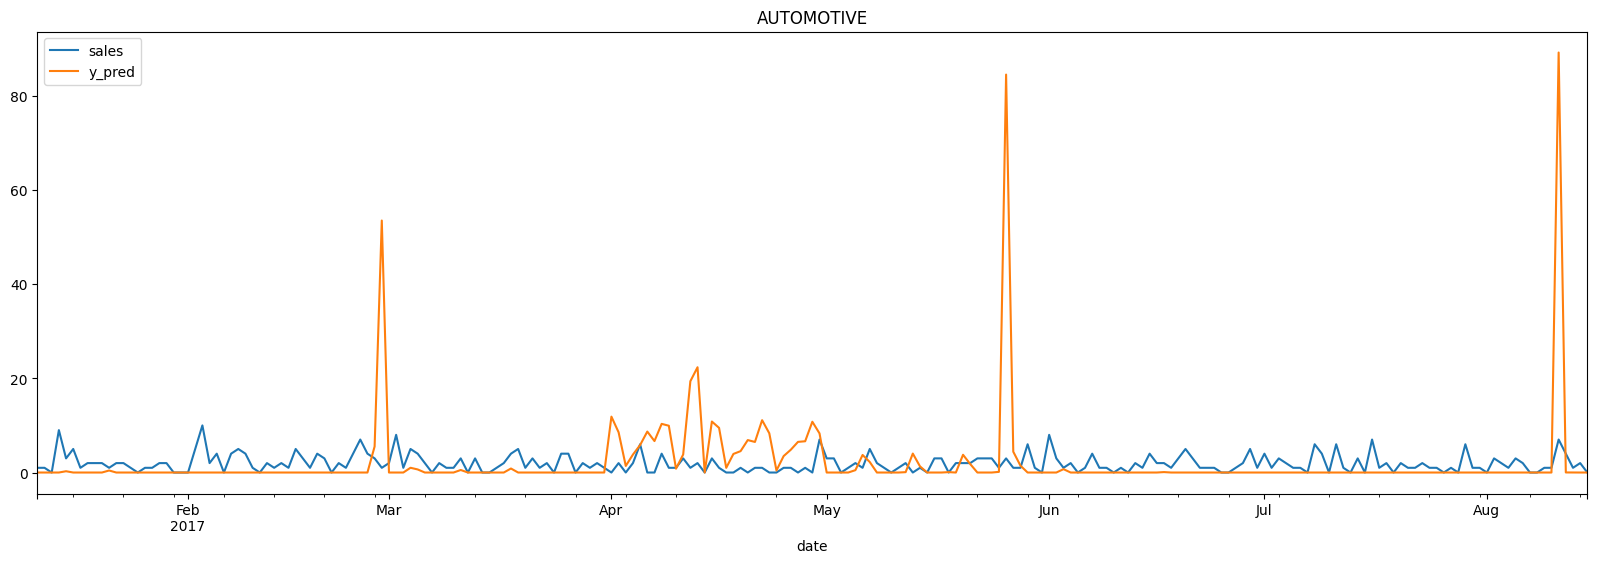

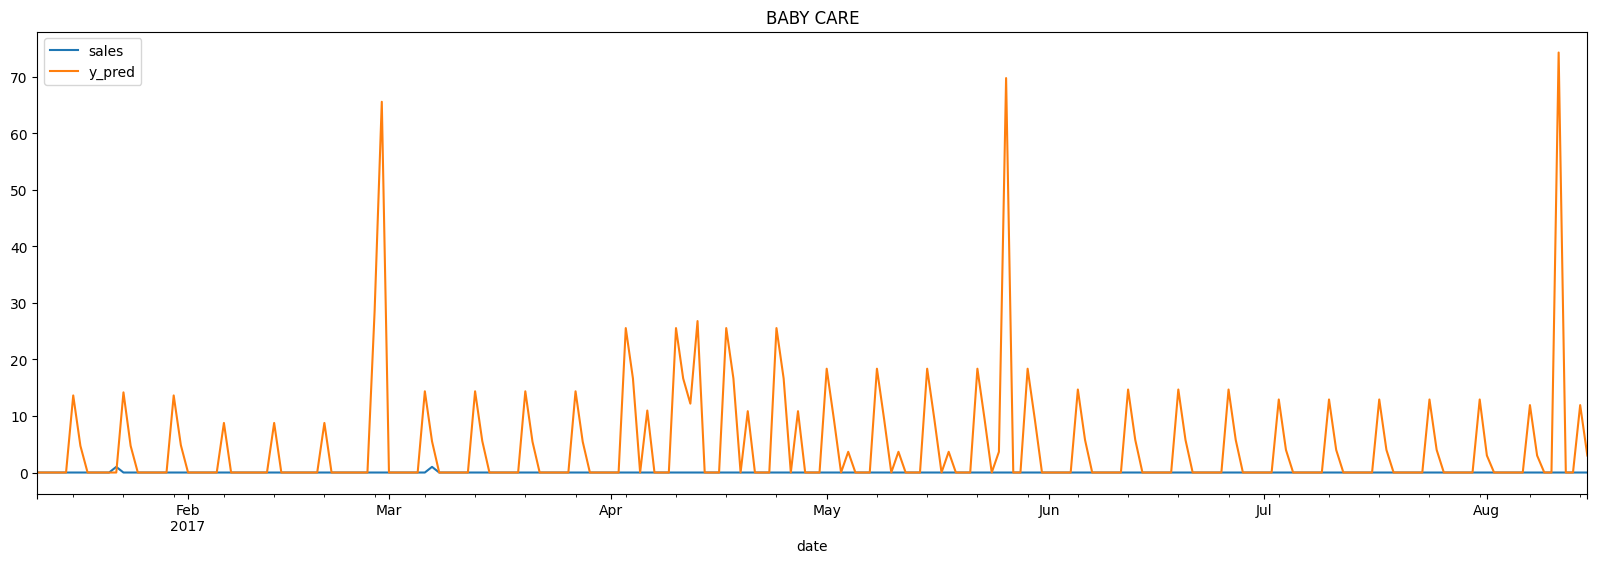

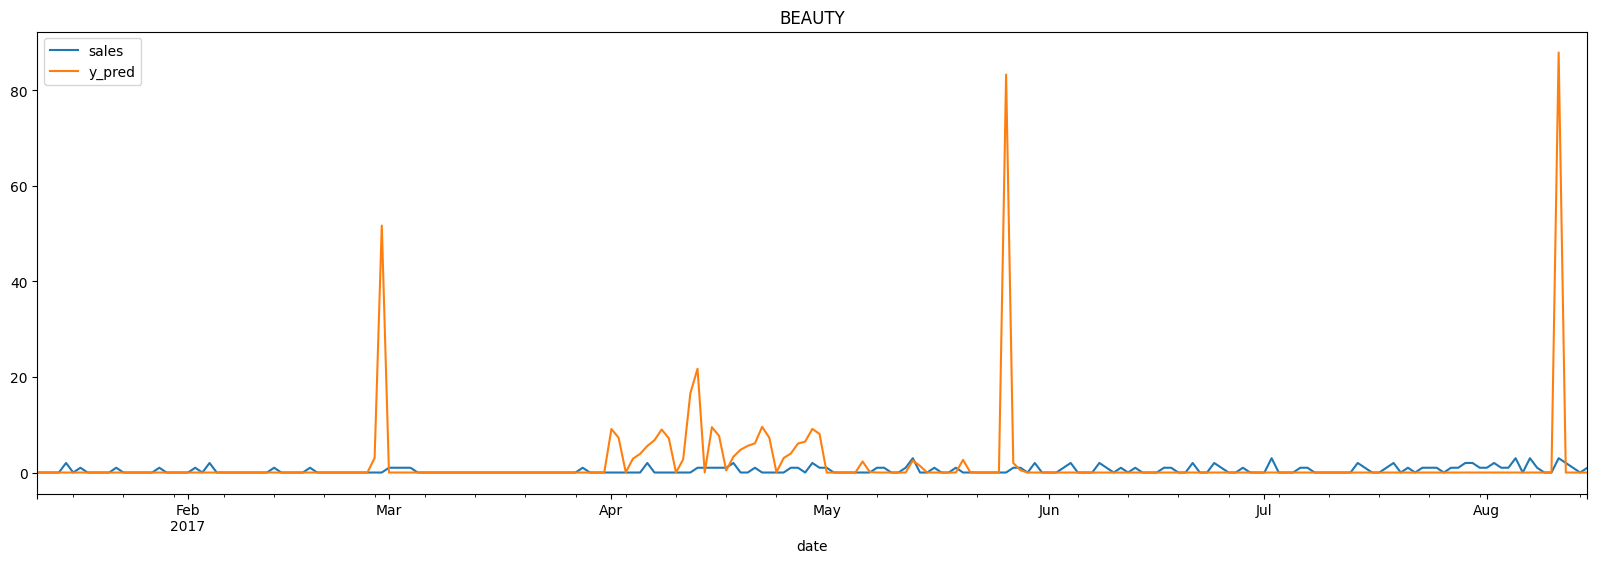

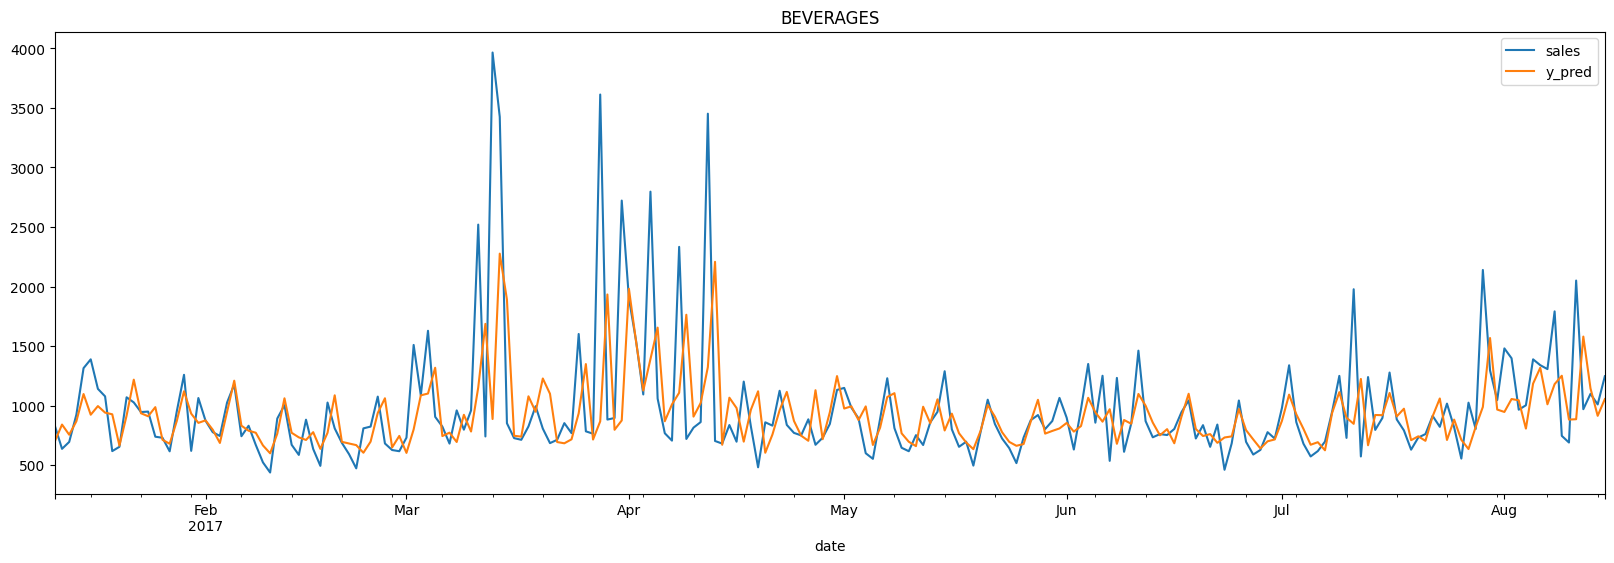

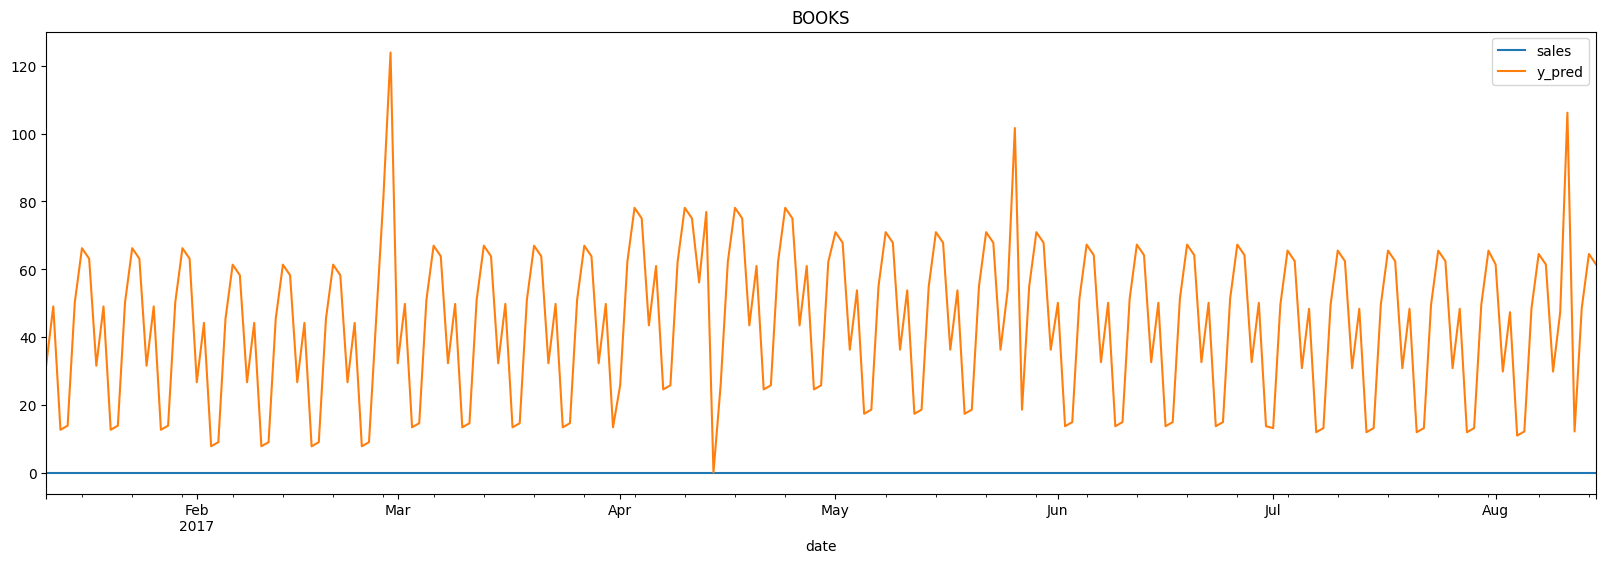

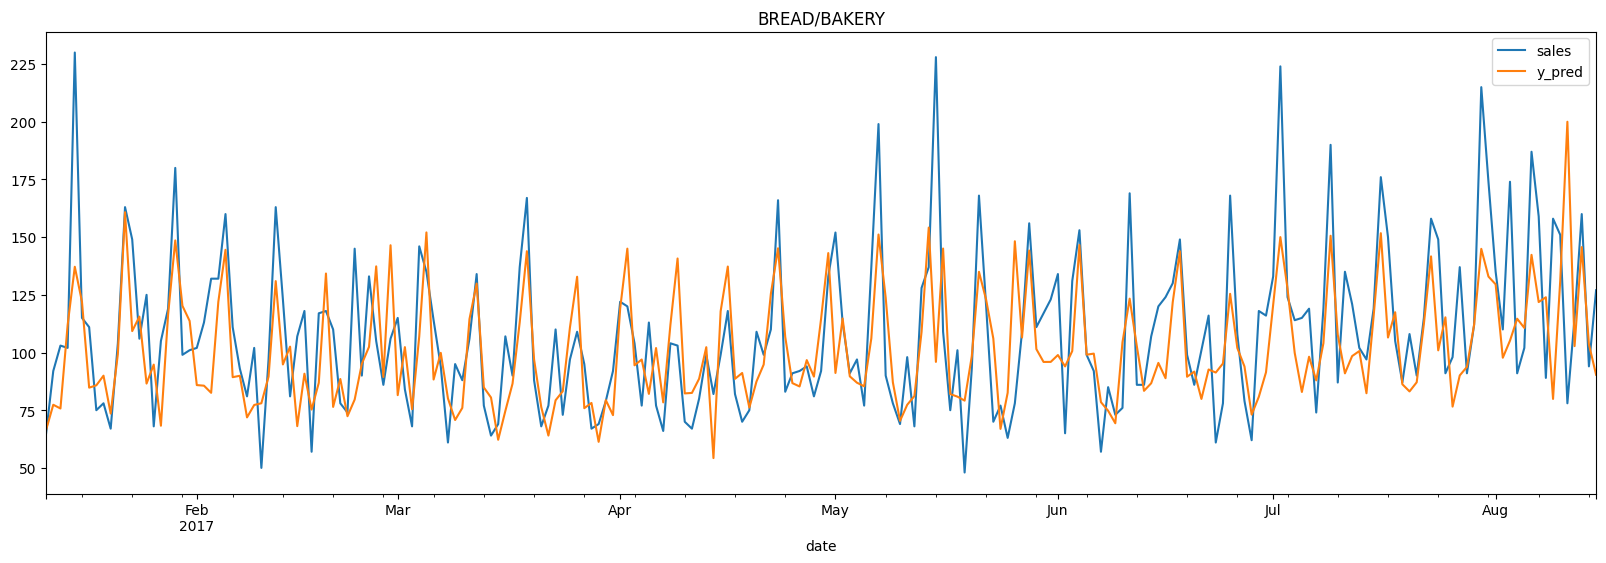

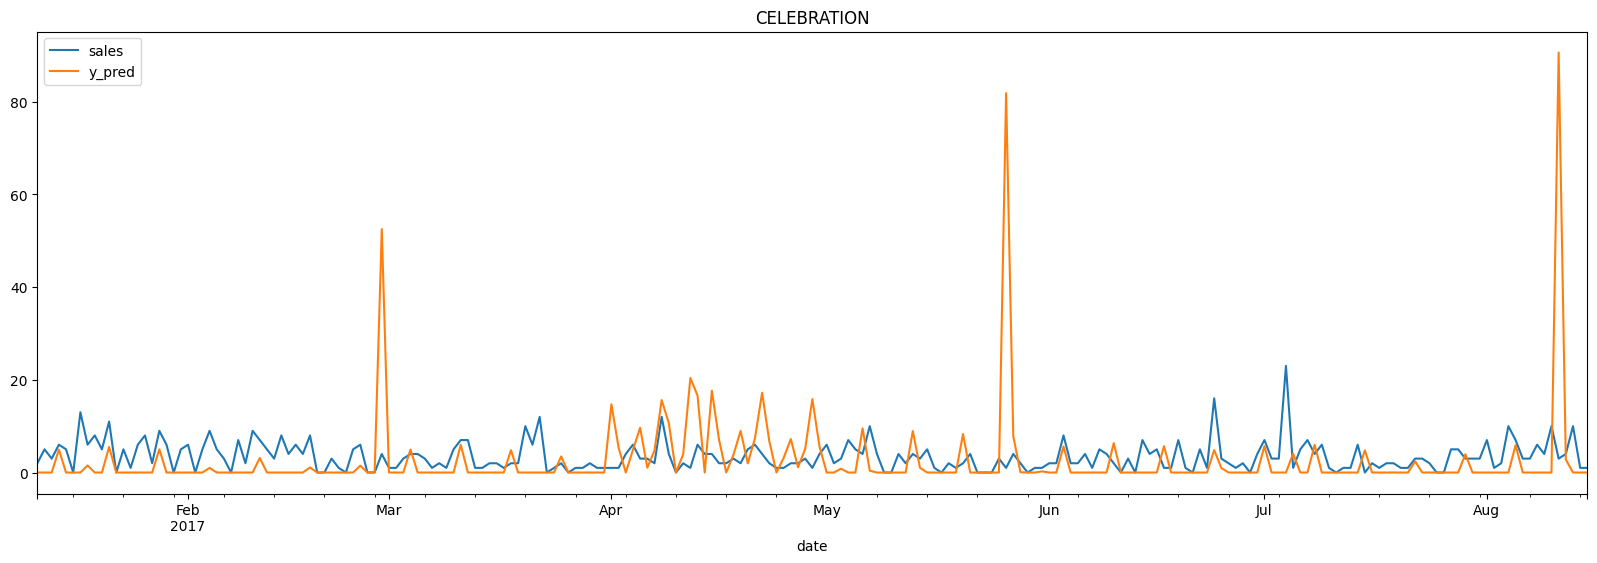

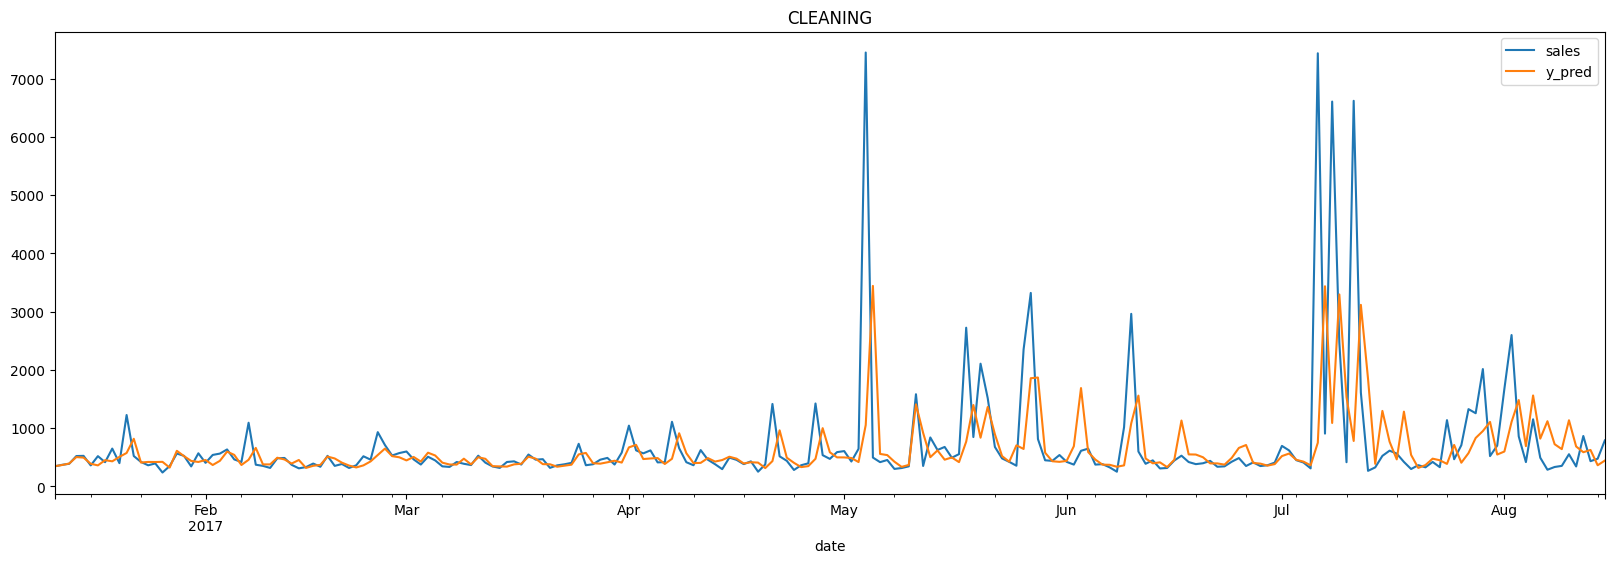

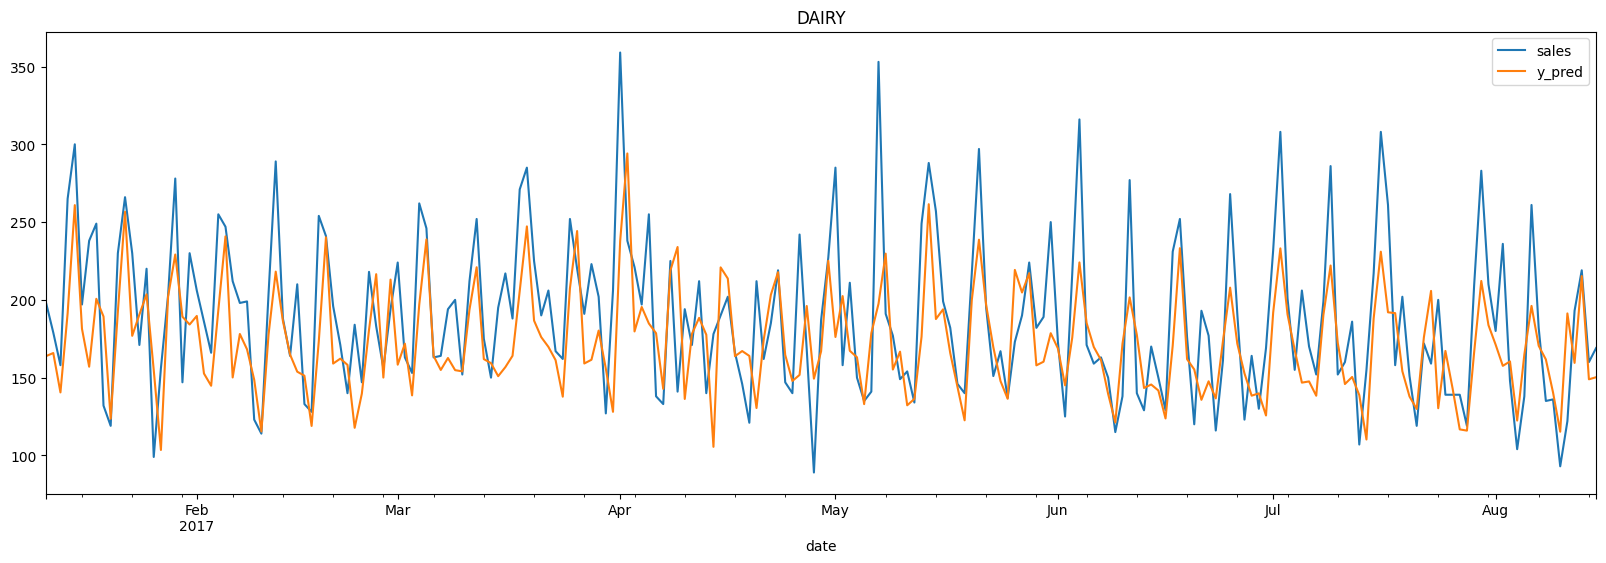

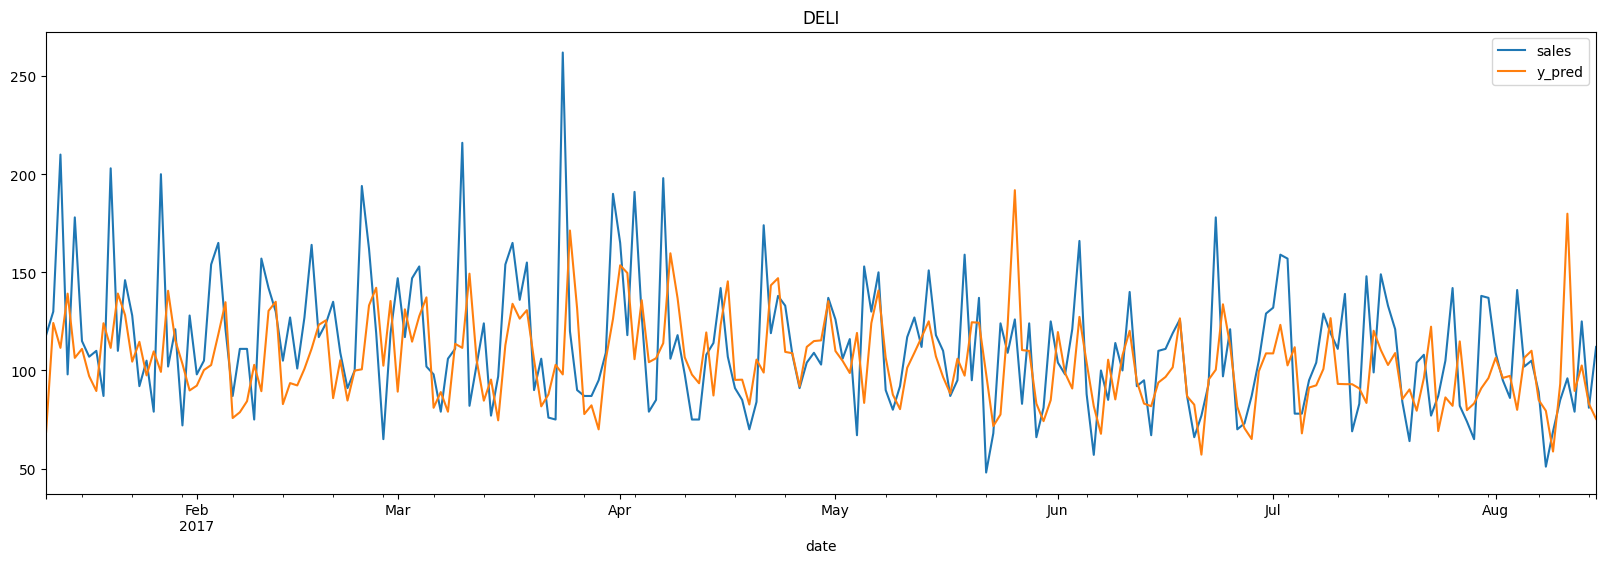

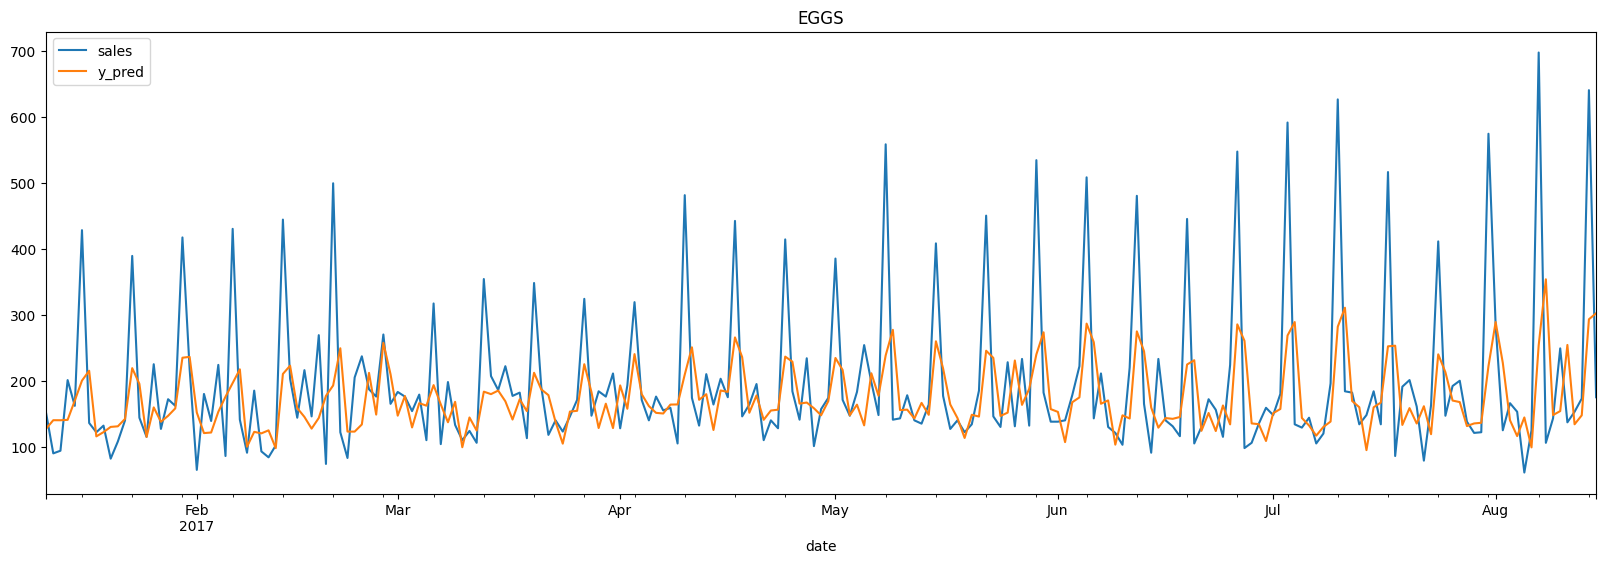

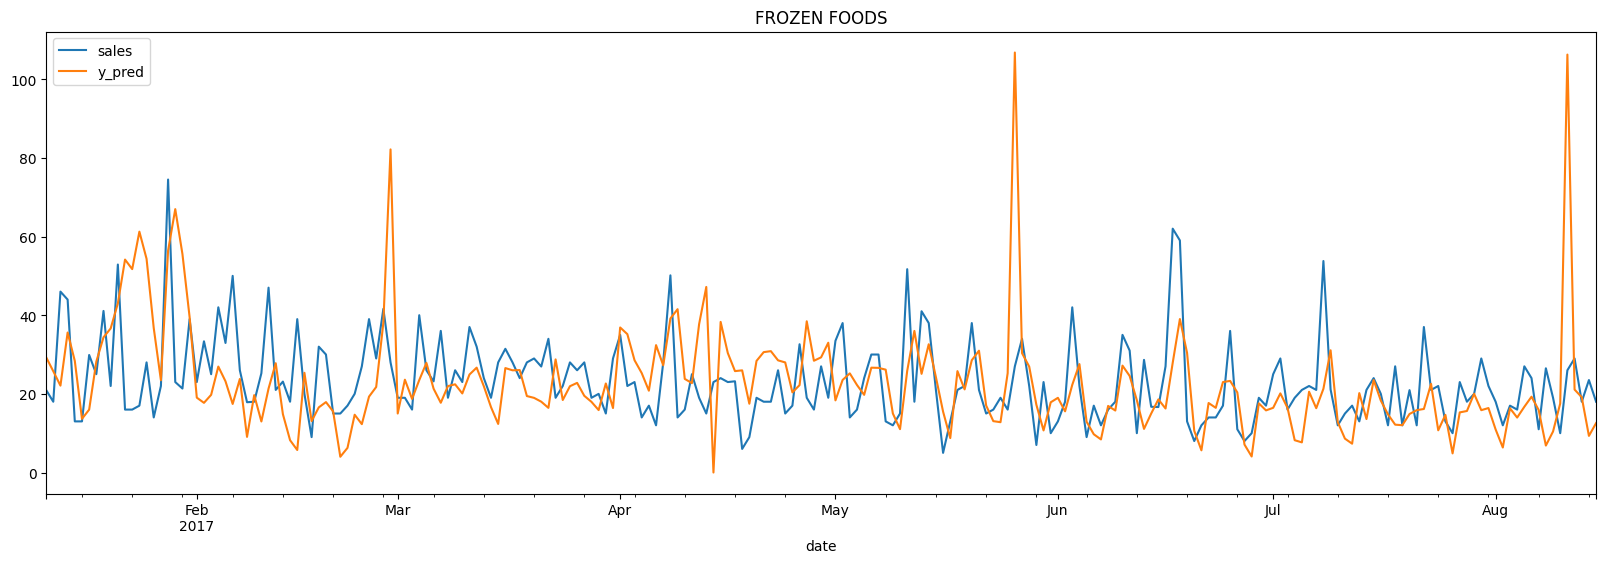

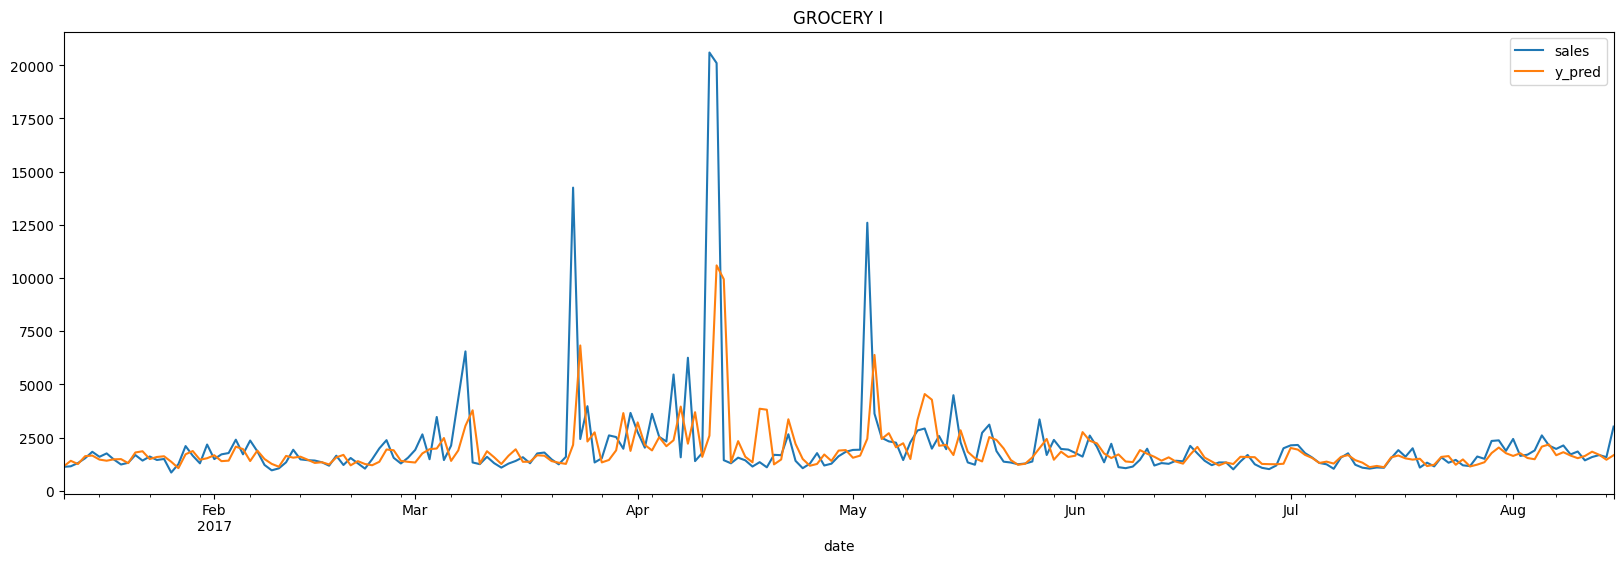

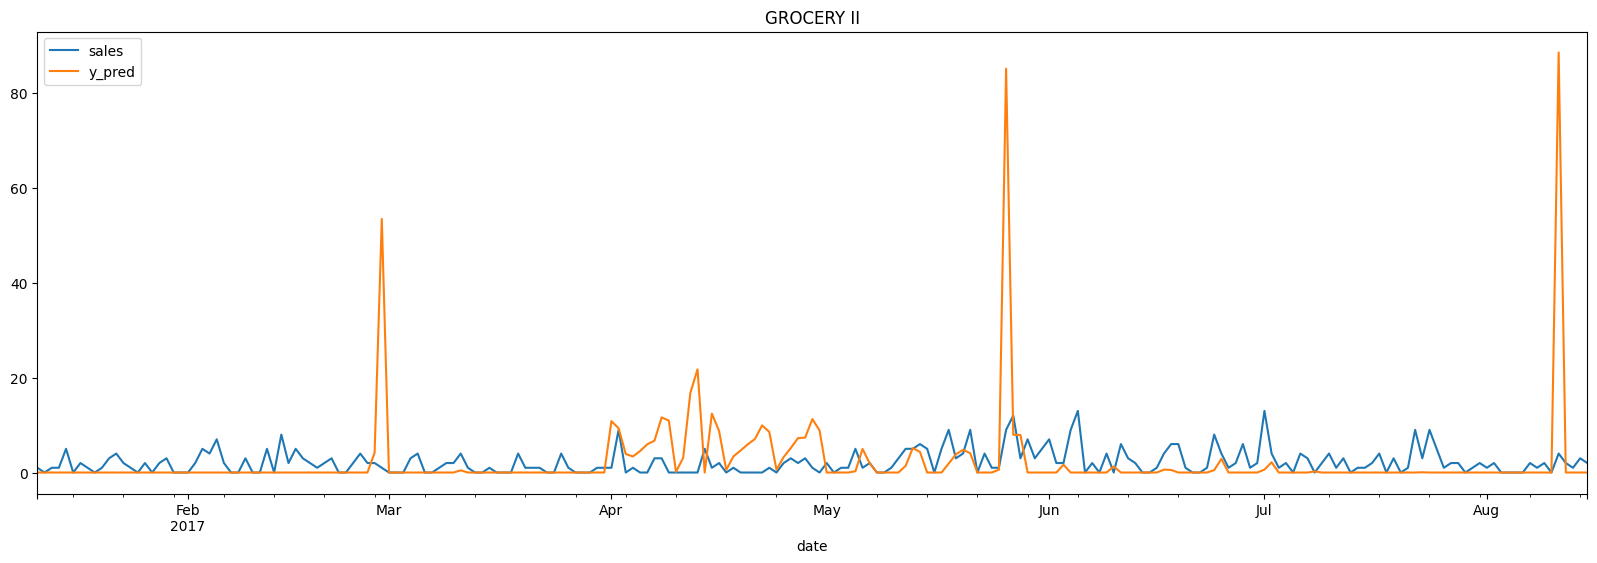

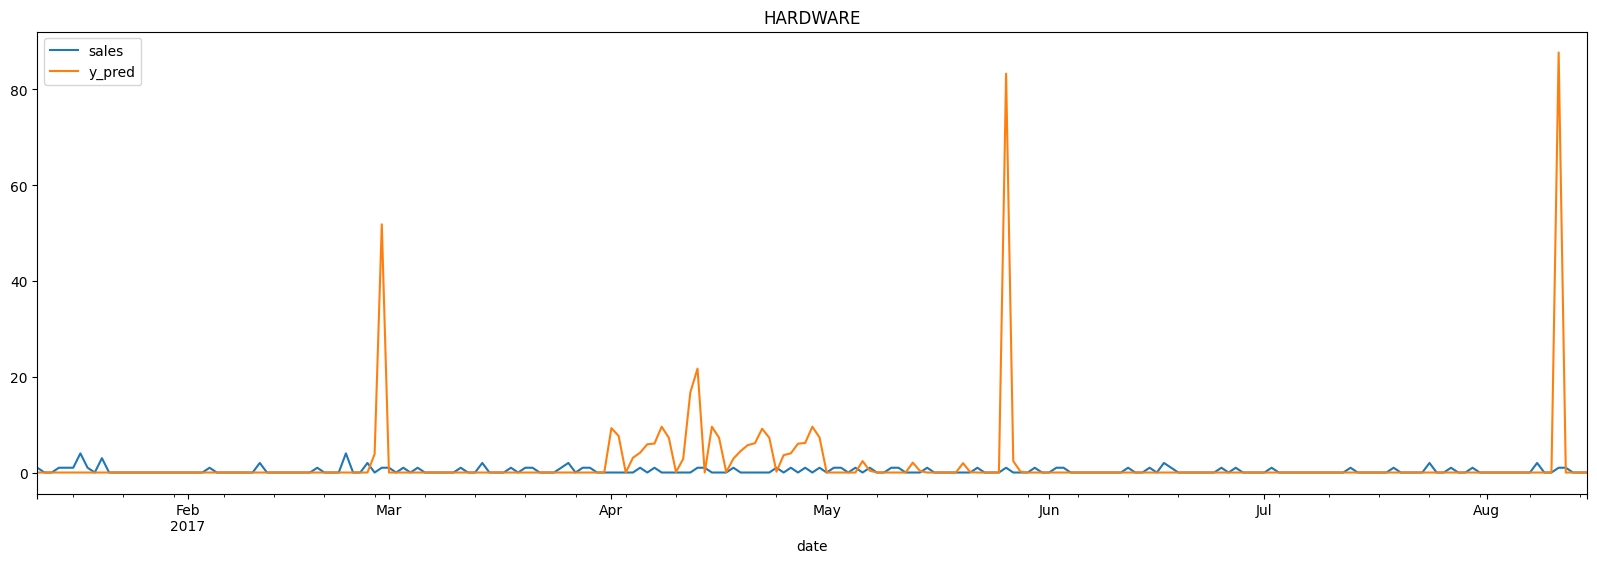

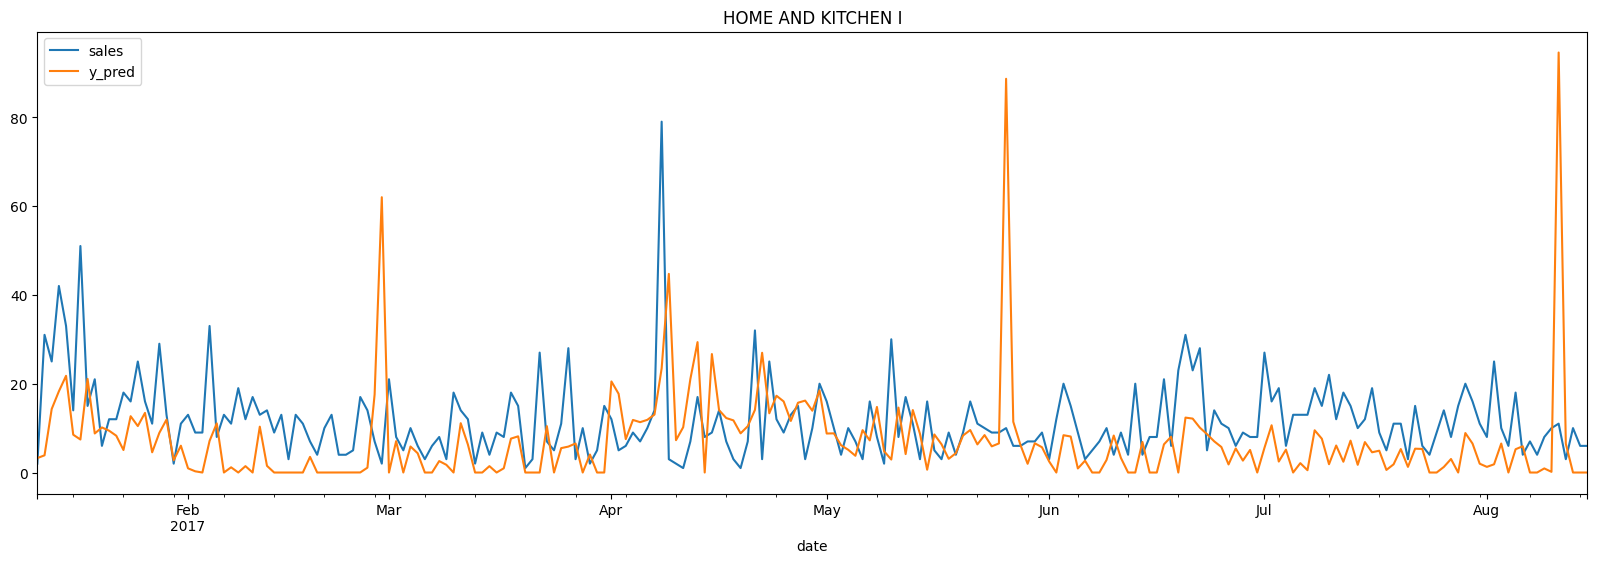

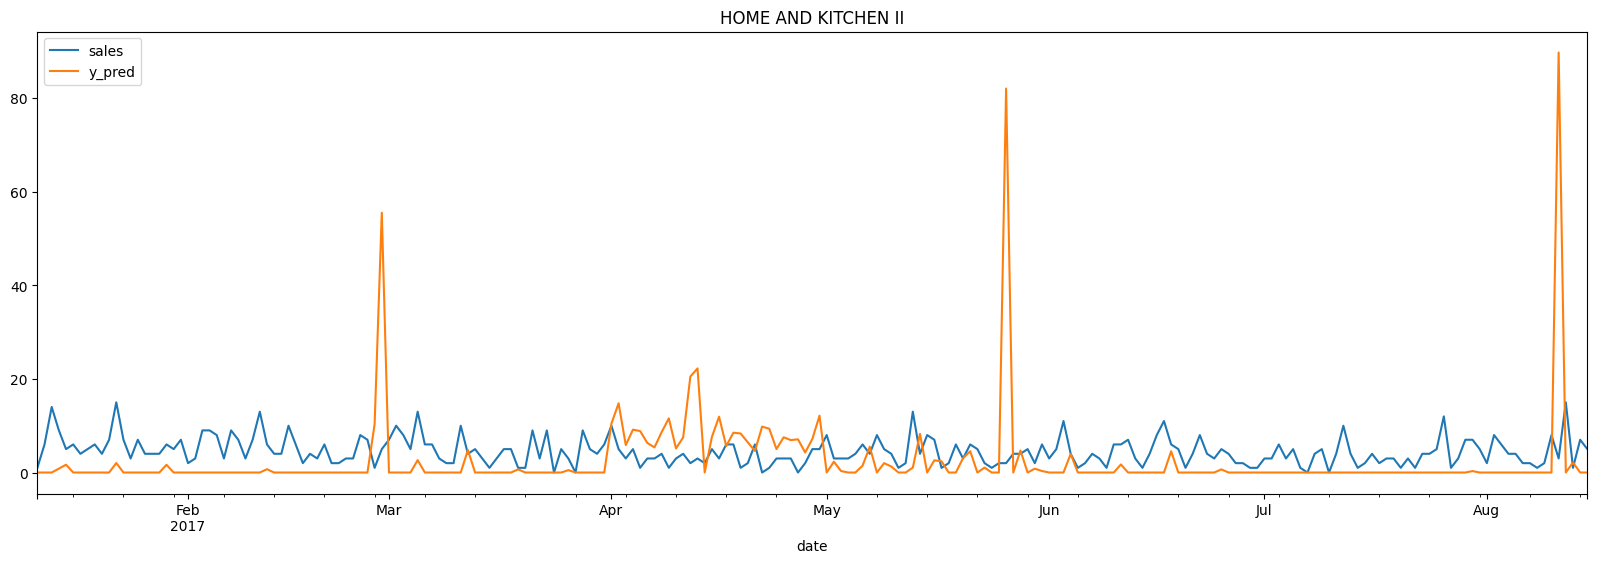

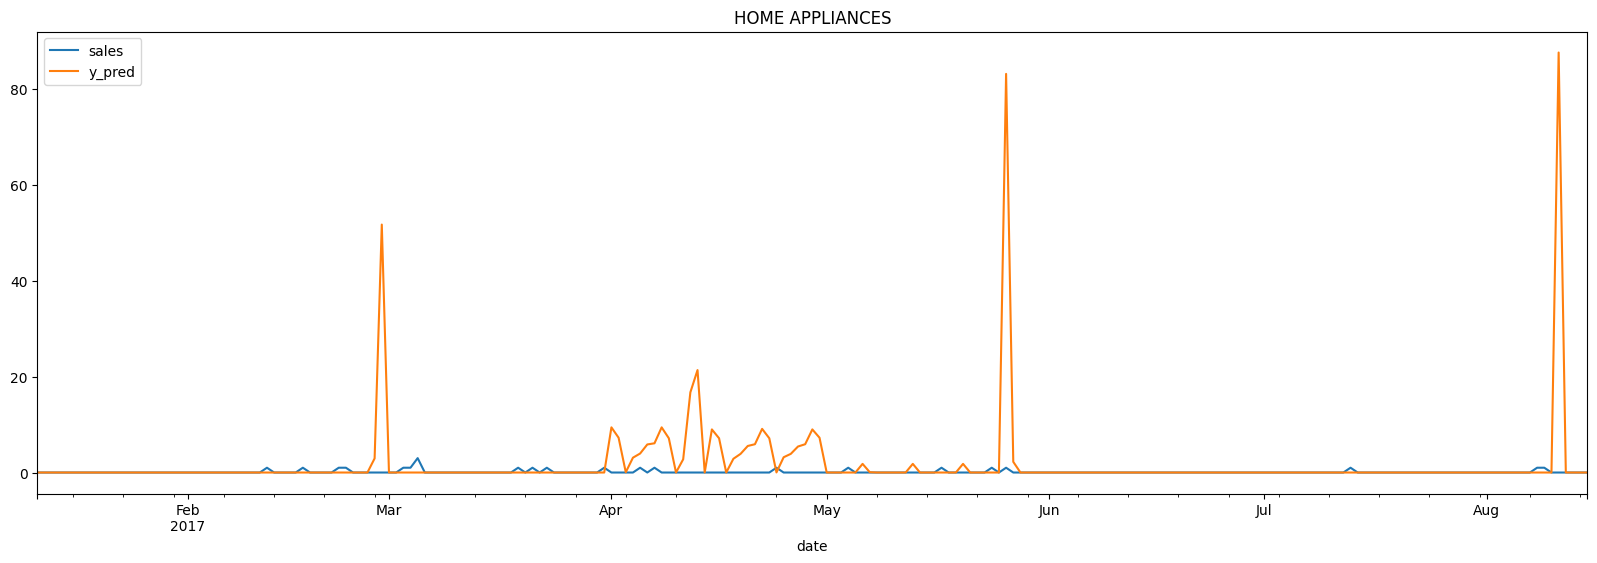

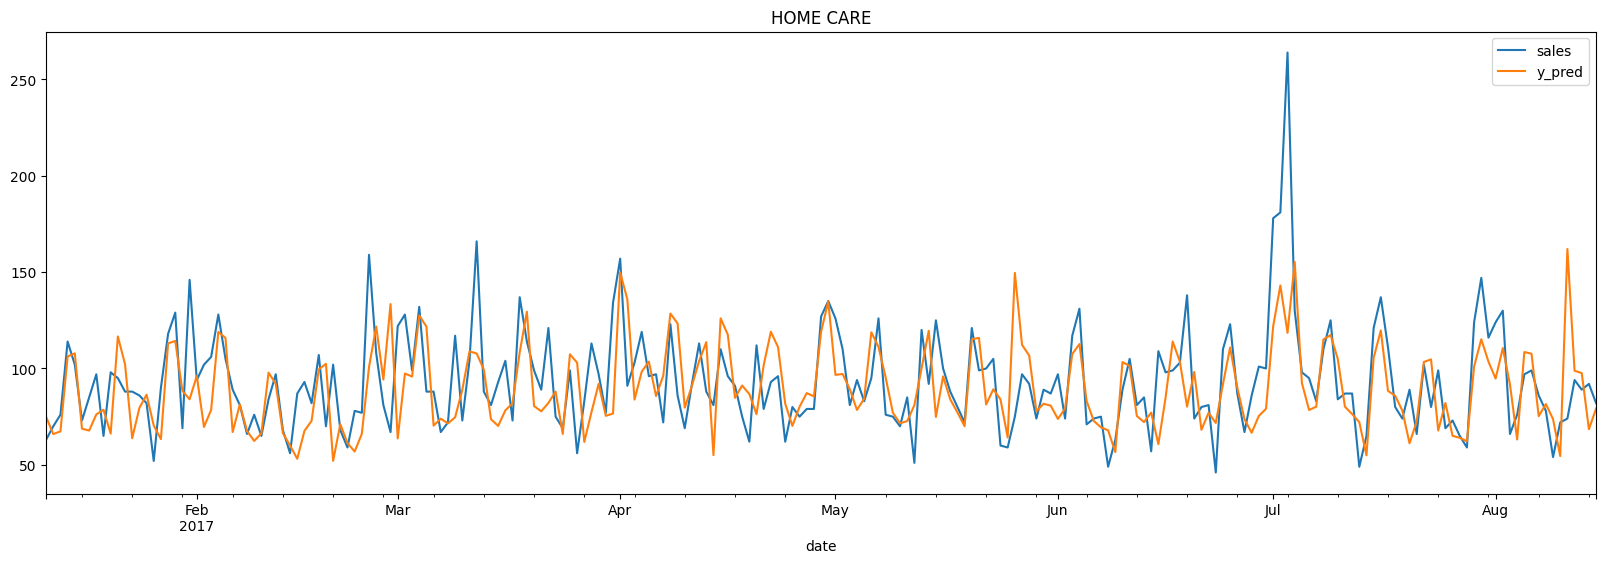

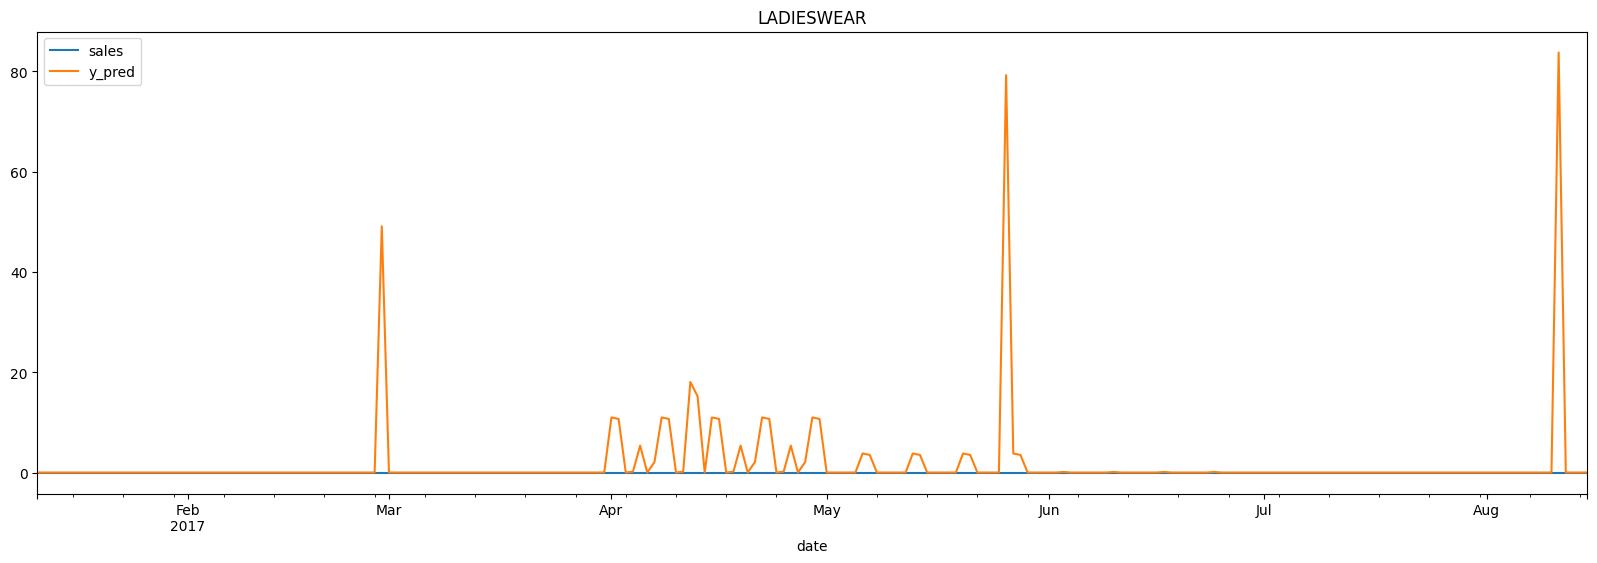

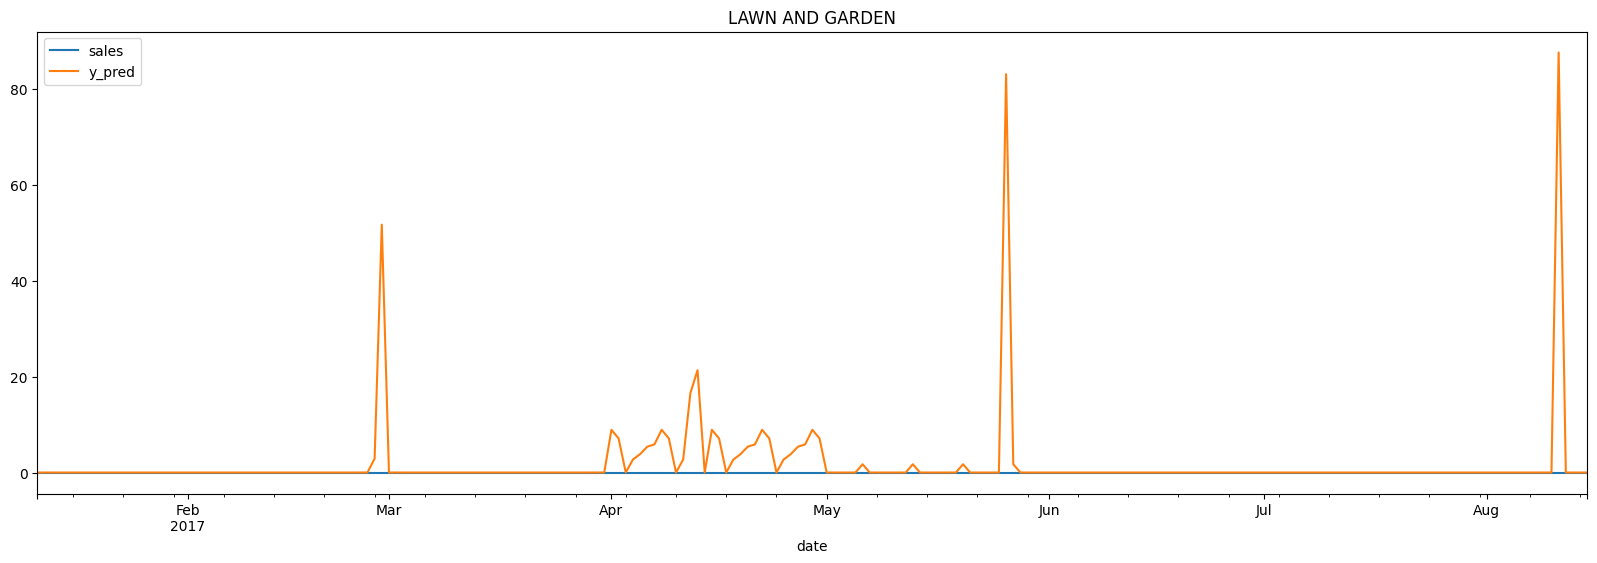

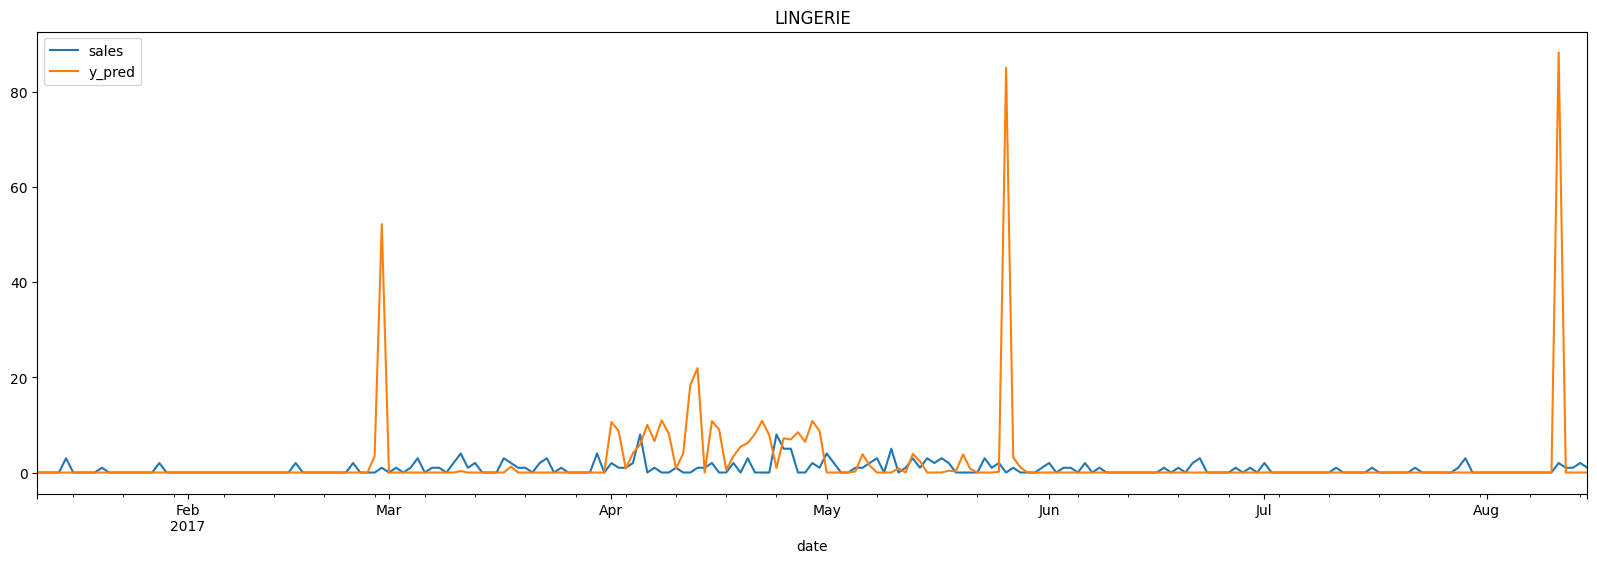

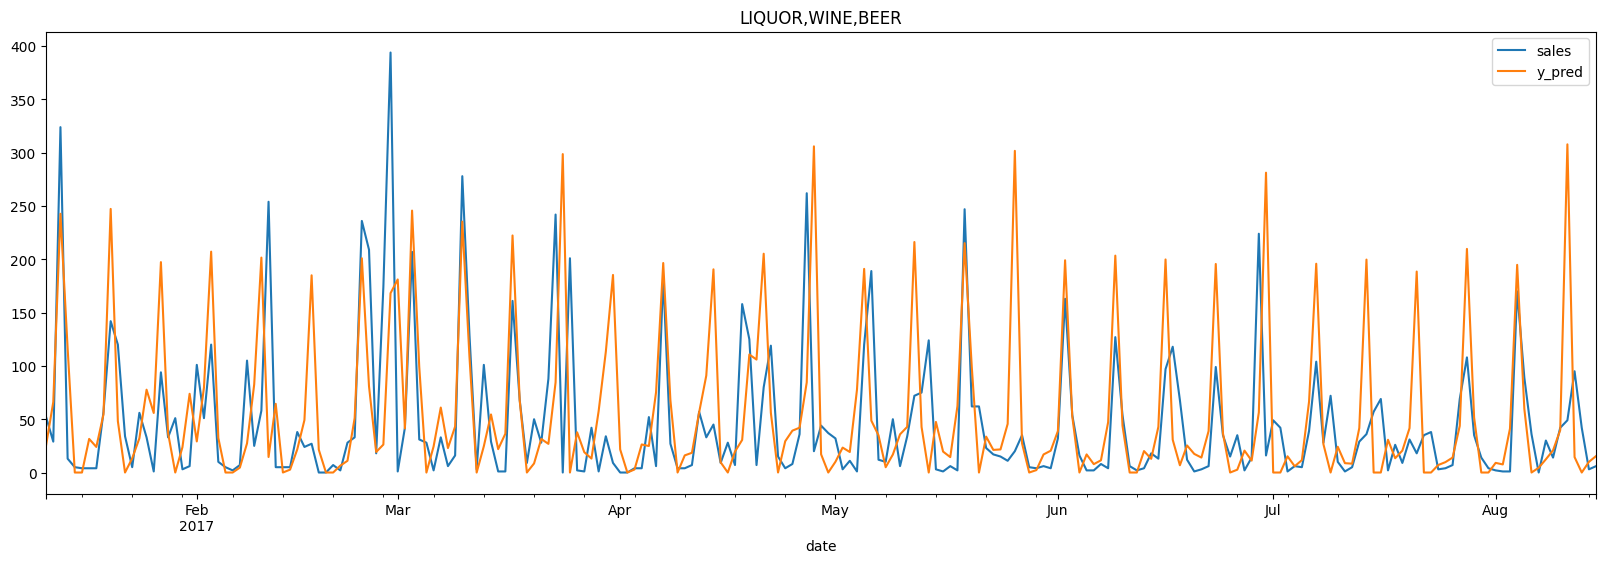

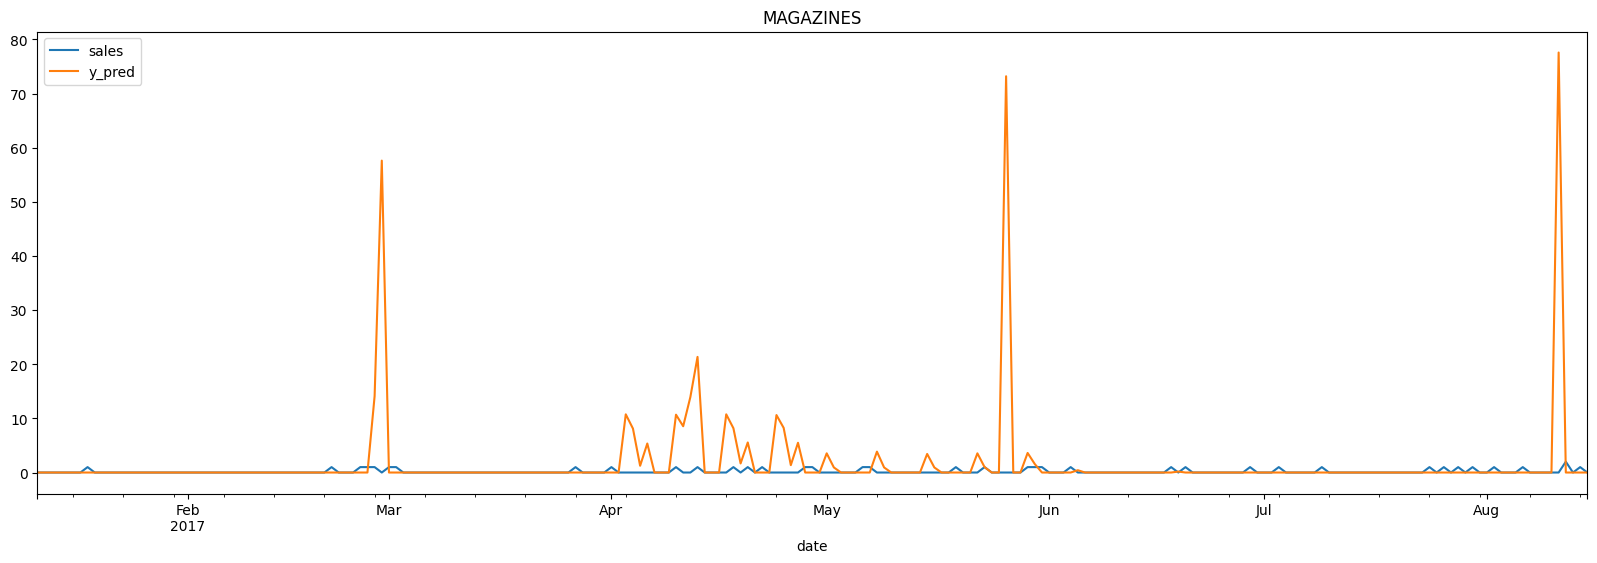

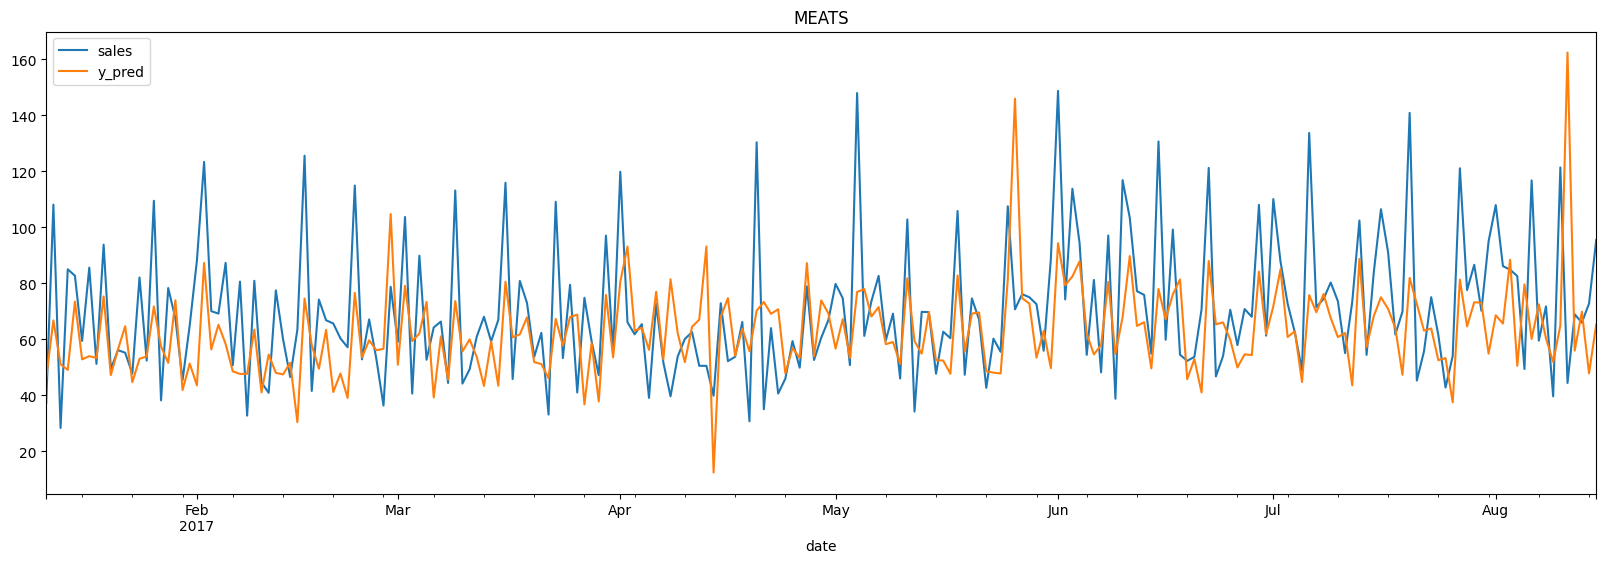

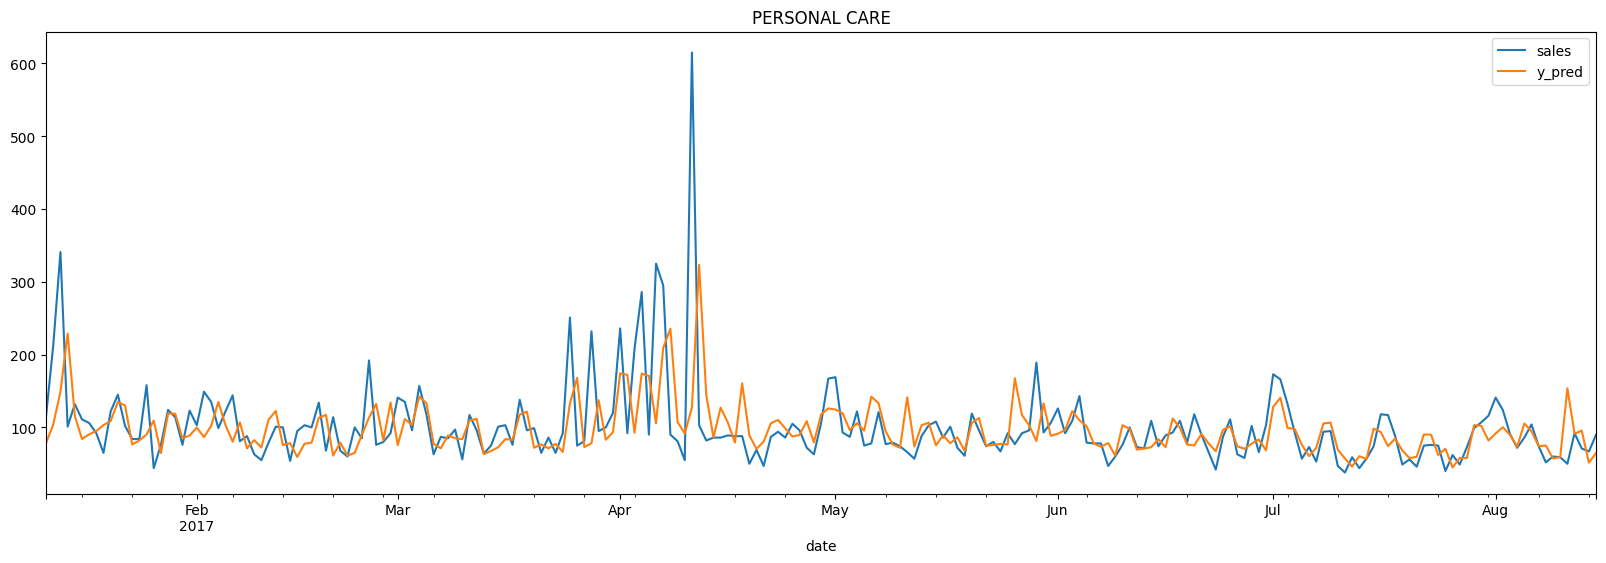

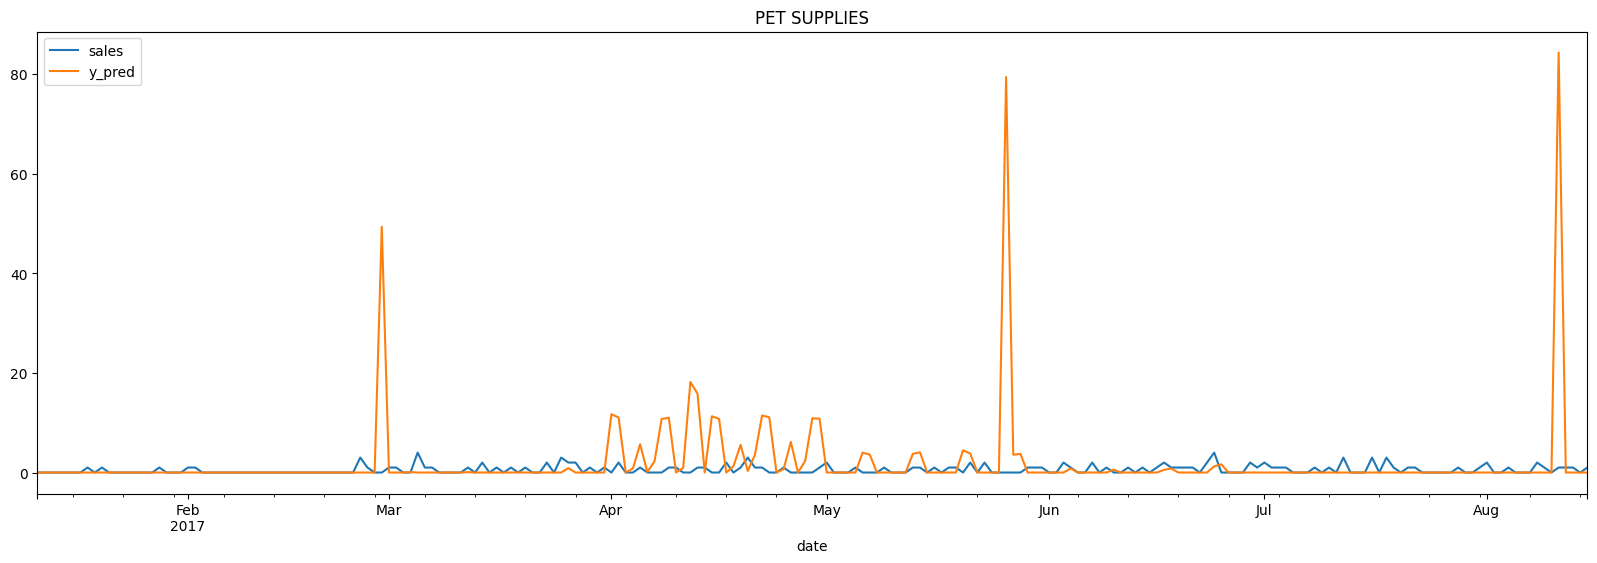

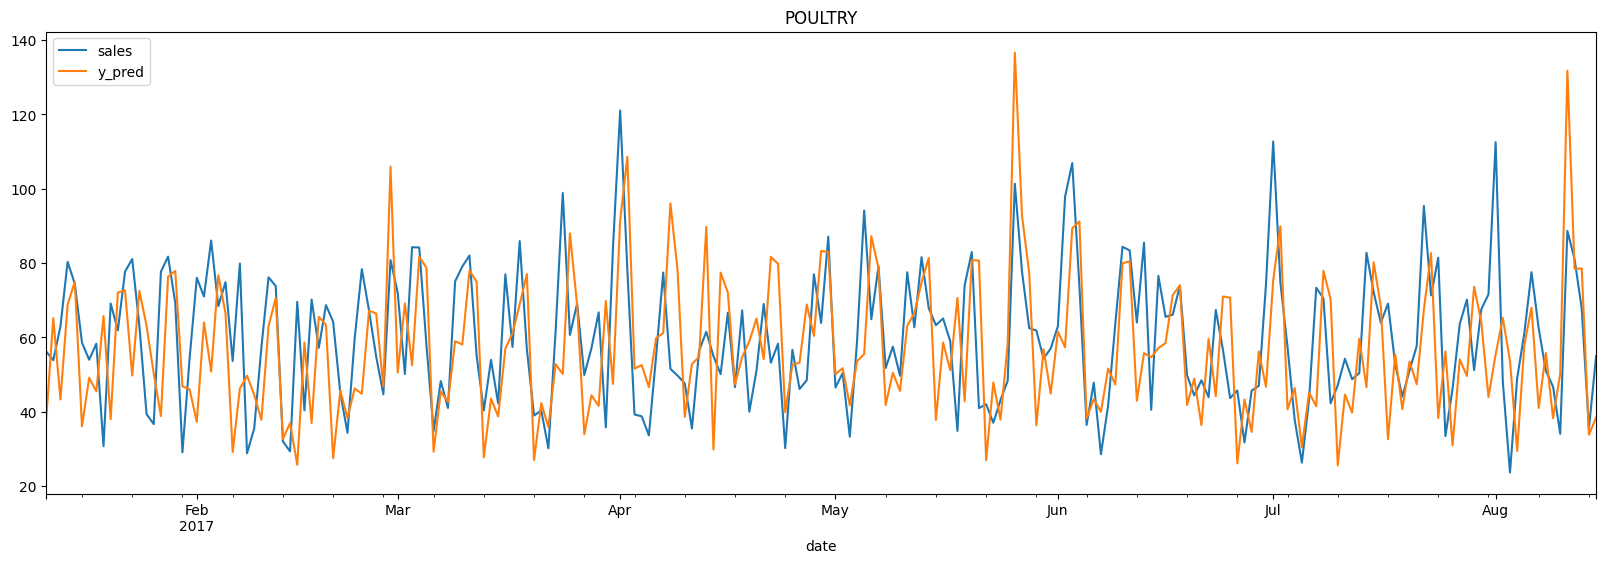

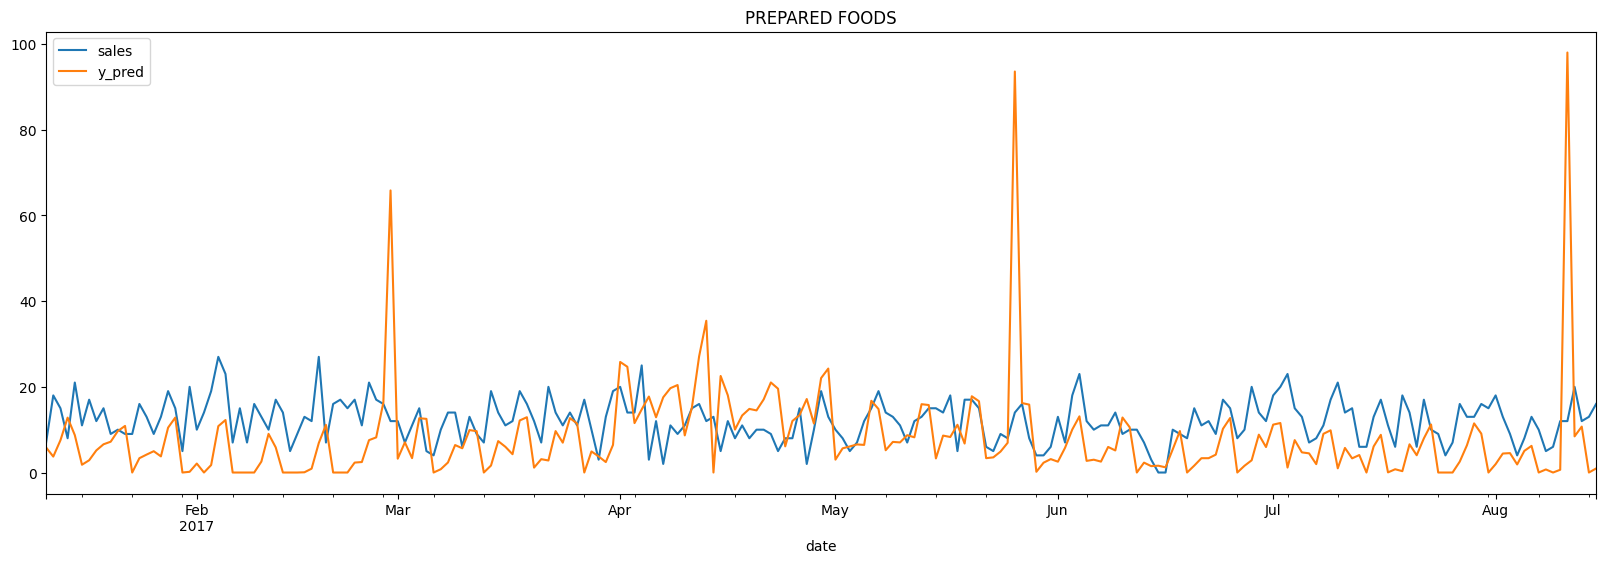

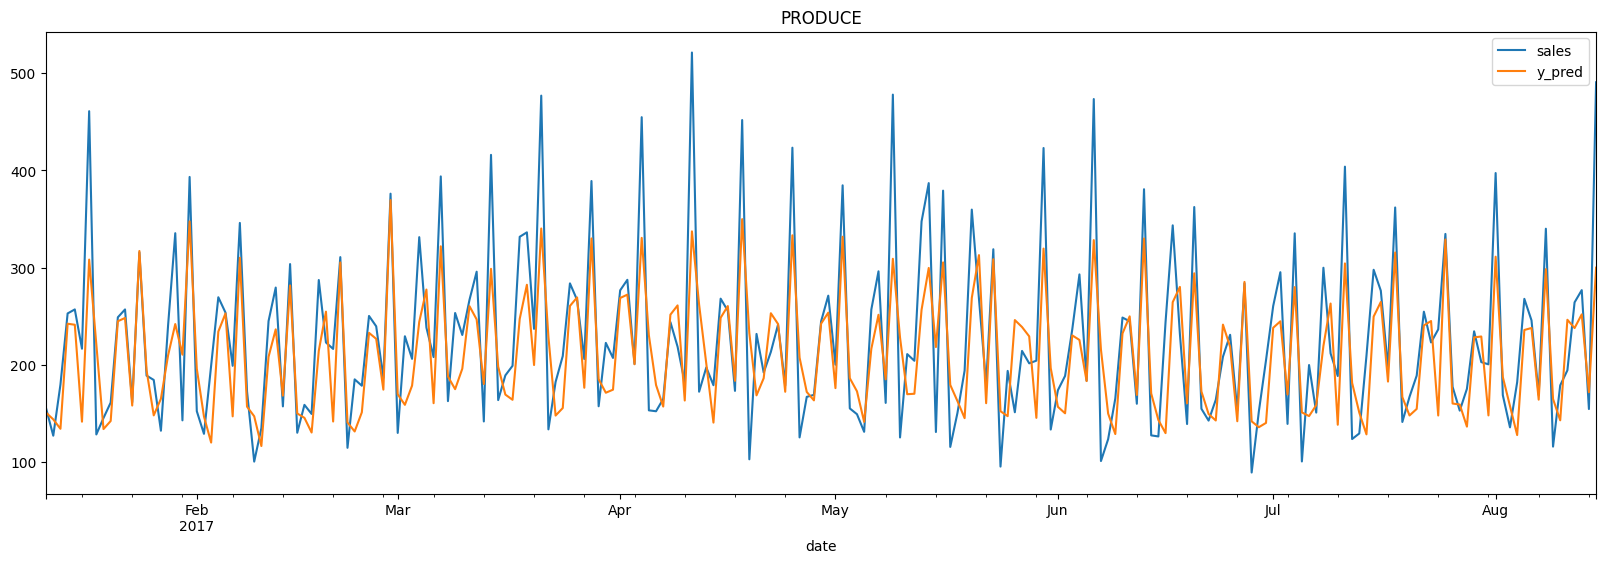

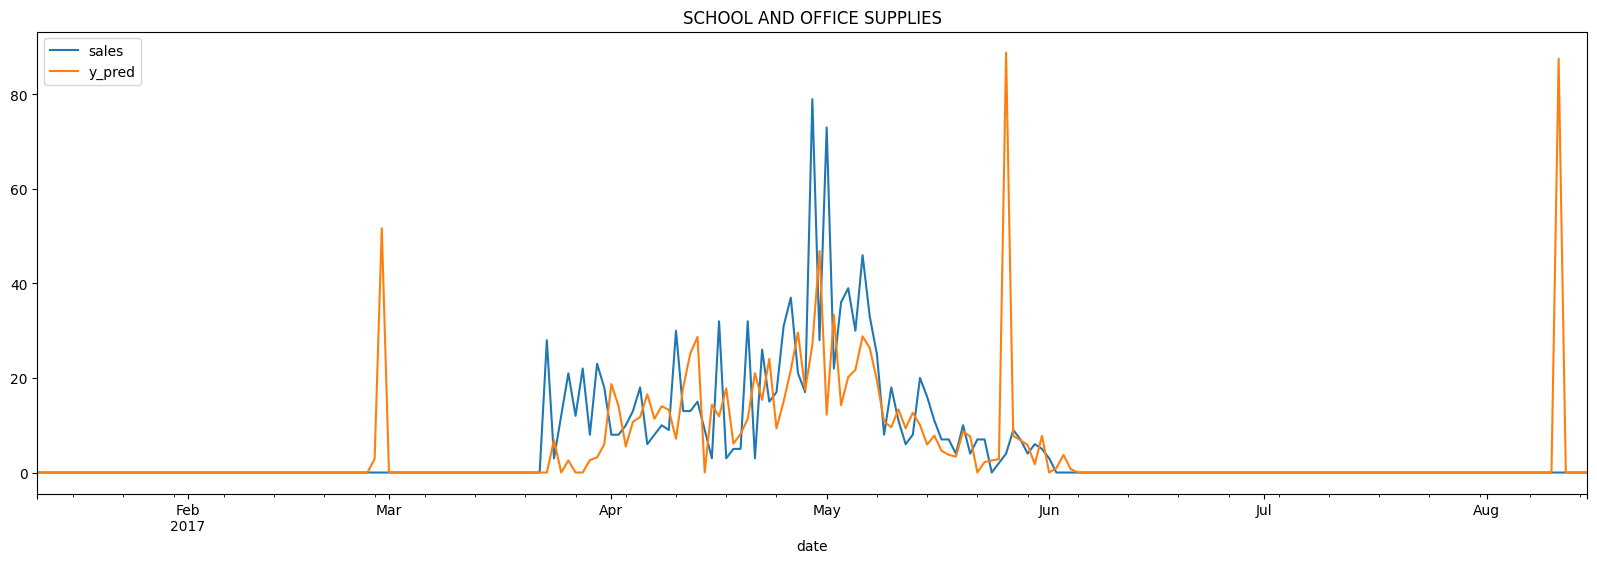

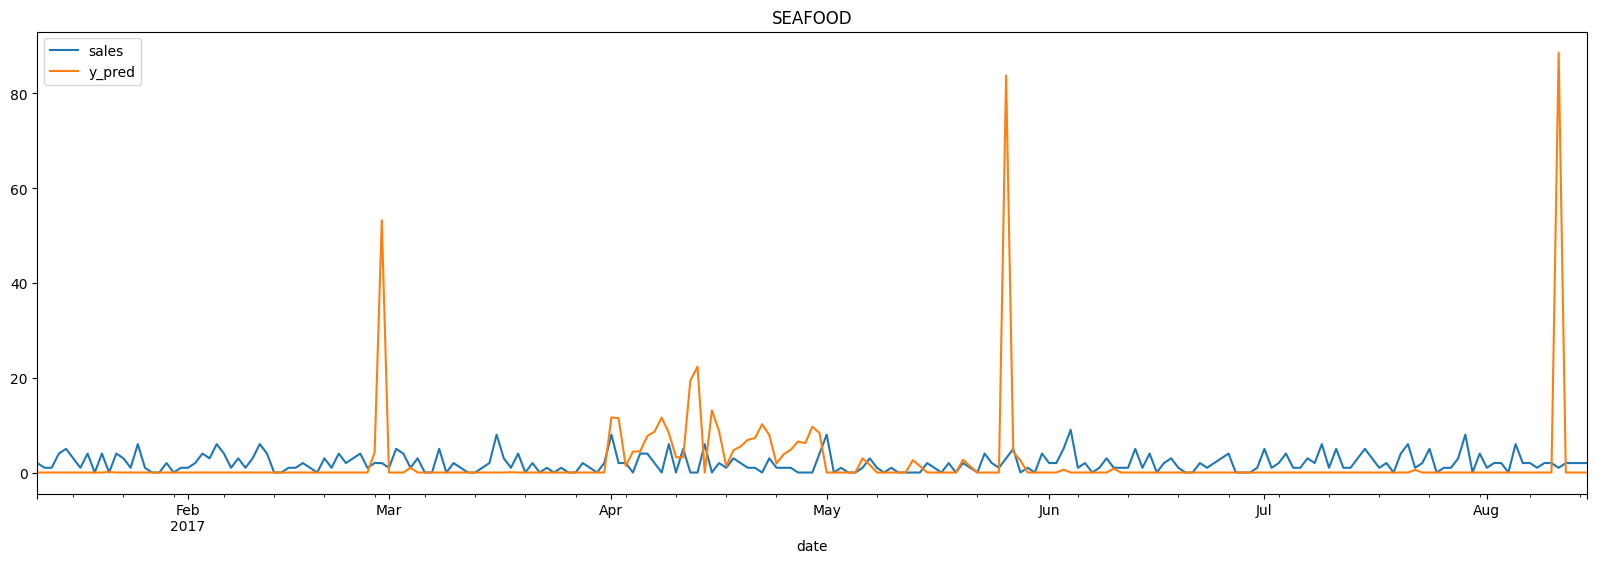

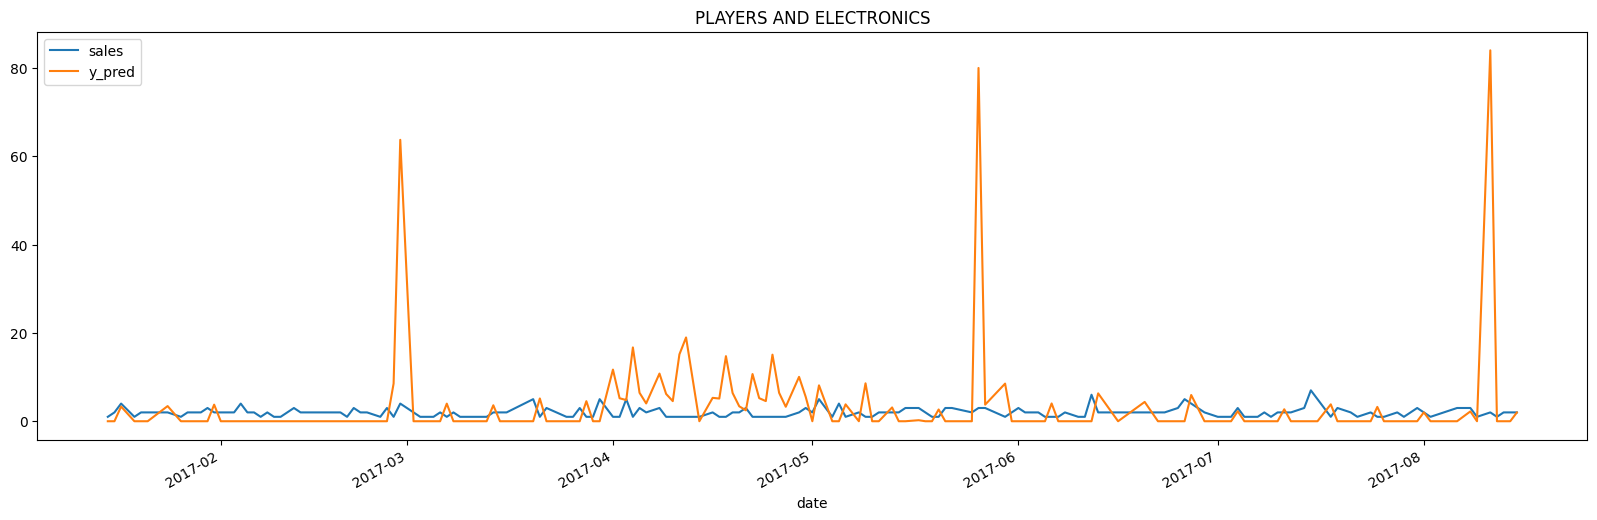

In [180]:
for i in list(train_32['family'].unique()):
    train_32.loc[train_32['family'] == i][['date','sales', 'y_pred']].groupby('date').sum().plot(figsize = (20,6), title = i)

In [50]:
# train.groupby('date')[['sales', 'transactions']].sum().corr()

In [51]:
# (train['sales'] / train['transactions'])